# Выявление профилей потребления

Интернет-магазин товаров для дома «Пока все ещё тут». Поможем  магазину стать лучше, а клиентам — обустроить дом своей мечты. Нужно выявить профиль покупателя, сегментировать  их.

### План исследования
1. [Загрузка данных и подготовка их к анализу](#preprocessing)
   - [Общая информация](#data_information)
   - [Пропуски и дубликаты](#omissions_and_duplicates)
   - [Выбросы](#data_outliers_preprocessing) 
   - [Выводы](#conclusion_preprocessing)
2. [Анализ данных](#data_analysis)
    - [Определение среднего количества товаров в заказе](#data_analysis_average_number_of_items_in_order)
    - [Определение среднего чека](#data_analysis_average_check)
    - [Определение категорий товаров](#data_analysis_product_categories)
    - [Определение сезонности товаров](#data_analysis_seasonality_of_goods)
    - [Определение самых популярных товаров](#data_analysis_most_popular_products)
    - [Выводы](#conclusion_data_analysis) 
3. [Кластеризация пользователей](#clustering_of_users)
   - [Выводы](#conclusion_clustering_of_users) 
4. [Проверка гипотез](#hypothesis_testing)
   - [Выводы](#conclusion_hypothesis_testing) 
6. [Выводы](#conclusion)

### Материалы
<a id="materials"></a> 

- [Дашборд](https://public.tableau.com/views/_16753633024520/sheet1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)


### Загрузка данных и подготовка их к анализу
<a id="preprocessing"></a> 

In [1]:
# имортируем библиотеки
from pathlib import Path
import re
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import math as mth
from scipy import stats as st
from itertools import combinations

In [2]:
# добавим форматирование вещественных чисел и тему для графиков
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('classic')
pd.options.display.max_colwidth = 400

In [3]:
# откроем табл
try:
    data = pd.read_csv(Path.cwd() /'datasets'/'ecommerce_dataset.csv')
except:
   print('не удалось открыть файл')

In [4]:
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00


#### Общая информация
<a id="data_information"></a> 

In [5]:
def general_check(df):
    display(df.head(10))
    print('Исходная информация \n')
    df.info()
    print()
    print(f'Размерность {df.shape}', end='\n')
    print('После переименования столбцов\n')
    df.columns = [re.sub( '(?<!^)(?=[A-Z])', '_', col ).lower() for col in df.columns]
    df.columns = [re.sub( '_i_d_', '_id_', col ).lower() for col in df.columns]
    df.info()

In [6]:
# посмотрим общ. инф. о табл.: первые 10 строк, инфо, переименуем столбцы, инфо
general_check(data)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.00
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.00
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.00
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.00
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.00


Исходная информация 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB

Размерность (6737, 6)
После переименования столбцов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        

Структура данных
 - `date` — дата заказа;
 - `customer_id` — идентификатор покупателя;
 - `order_id` — идентификатор заказа;
 - `product` — наименование товара;
 - `quantity` — количество товара в заказе;
 - `price` — цена товара.

Создадим столбцы с месяцем и годом заказа и общей суммой заказа

In [7]:
data['date_year_month'] = pd.to_datetime(data['date'], format='%Y%m%d%H').astype('datetime64[M]')
data['total_price'] = data['quantity']*data['price']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             6737 non-null   int64         
 1   customer_id      6737 non-null   object        
 2   order_id         6737 non-null   int64         
 3   product          6737 non-null   object        
 4   quantity         6737 non-null   int64         
 5   price            6737 non-null   float64       
 6   date_year_month  6737 non-null   datetime64[ns]
 7   total_price      6737 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 421.2+ KB


In [8]:
data.head()

,date,customer_id,order_id,product,quantity,price,date_year_month,total_price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00,2018-10-01,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.00,2018-10-01,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00,2018-10-01,112.00
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00,2018-10-01,179.00
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00,2018-10-01,112.00


#### Пропуски и дубликаты
<a id="omissions_and_duplicates"></a> 

In [9]:
def general_check_skipping_duplicates(df):
    print('Пропуски в столбцах')
    skipping = pd.DataFrame(
        (df.isna().sum())
        .to_frame()
        .rename(columns = {0:'space'})
        .sort_values(by = 'space', ascending = True)
    ).style.background_gradient('coolwarm')
    display(skipping)
    
    sh_original = df.shape[0]
    df.duplicated().sum()
    if df.duplicated().sum() > 0:
        df = df.drop_duplicates().reset_index(drop = True)
        sh_filter = df.shape
        delta_df = sh_original - sh_filter[0]
        print(f'Удалили {delta_df} явных дубликатов. Размерность стала {sh_filter}')
    else:
        print('Явных дубликатов нет')

In [10]:
# посмотрим пропуски и явные дубликаты
general_check_skipping_duplicates(data)

Пропуски в столбцах


,space
date,0
customer_id,0
order_id,0
product,0
quantity,0
price,0
date_year_month,0
total_price,0


Явных дубликатов нет


In [11]:
def check_lower_duplicate(df, col=None):
    data_lower = df.copy()
    str_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
    return data_lower.duplicated(col).sum()

Проверим неявные дубликаты:
 - посмотрим есть ли дубликаты, если привести к нижнему регистру всю табл.
 - посмотрим есть ли дубликаты без учета даты

In [12]:
check_lower_duplicate(data)

0

In [13]:
data['product'] = data['product'].str.lower()
data.head()

,date,customer_id,order_id,product,quantity,price,date_year_month,total_price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.00,2018-10-01,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.00,2018-10-01,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.00,2018-10-01,112.00
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.00,2018-10-01,179.00
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.00,2018-10-01,112.00


In [14]:
check_lower_duplicate(data, col=['customer_id', 'order_id', 'product', 'quantity', 'price'])

1864

У нас есть 1864 дубликата без учета даты, удалим их.

In [15]:
data = data.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'])
check_lower_duplicate(data, ['customer_id', 'order_id', 'product', 'quantity', 'price'])

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4873 entries, 0 to 6735
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             4873 non-null   int64         
 1   customer_id      4873 non-null   object        
 2   order_id         4873 non-null   int64         
 3   product          4873 non-null   object        
 4   quantity         4873 non-null   int64         
 5   price            4873 non-null   float64       
 6   date_year_month  4873 non-null   datetime64[ns]
 7   total_price      4873 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 342.6+ KB


#### Выбросы
<a id="data_outliers_preprocessing"></a> 

Проверим данные на аномальные значения цены и количества товара.

In [17]:
data.describe()[['quantity', 'total_price']]

,quantity,total_price
count,4873.00,4873.00
mean,2.84,850.02
std,17.61,9807.31
min,1.00,9.00
25%,1.00,120.00
50%,1.00,194.00
75%,1.00,734.00
max,1000.00,675000.00


In [18]:
min_price = data['total_price'].min()
max_price = data['total_price'].max()
data.query('total_price == @min_price or total_price == @max_price')

,date,customer_id,order_id,product,quantity,price,date_year_month,total_price
1078,2018120311,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"львиный зев волшебный ковер 0,05 г 4660010779639",1,9.00,2018-12-01,9.00
2159,2019030415,0f47231c-3a68-404a-88f7-08a4a172c17f,14559,"горох амброзия 10,0 г 4660010772616",1,9.00,2019-03-01,9.00
5456,2019061815,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000",1000,675.00,2019-06-01,675000.00
5642,2019070322,1ec1ad59-a29b-4949-929d-f4fc4fe14758,14887,"алиссум (лобулярия) снежные одежды 0,2 г 4650091480302",1,9.00,2019-07-01,9.00


In [19]:
max_quantity = data['quantity'].max()
data.query('quantity == @max_quantity')

,date,customer_id,order_id,product,quantity,price,date_year_month,total_price
5456,2019061815,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000",1000,675.00,2019-06-01,675000.00


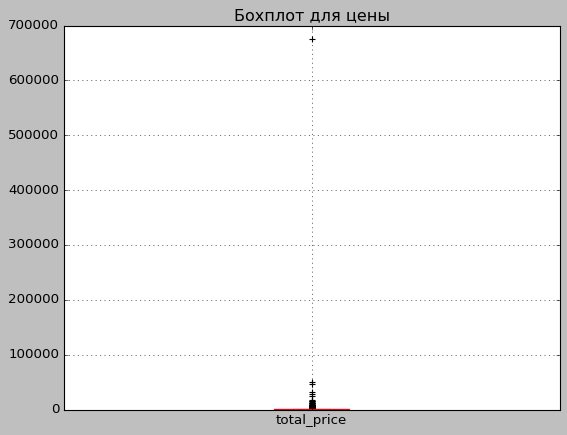

In [20]:
data.boxplot(column=['total_price'])
plt.title('Бохплот для цены')
plt.show()

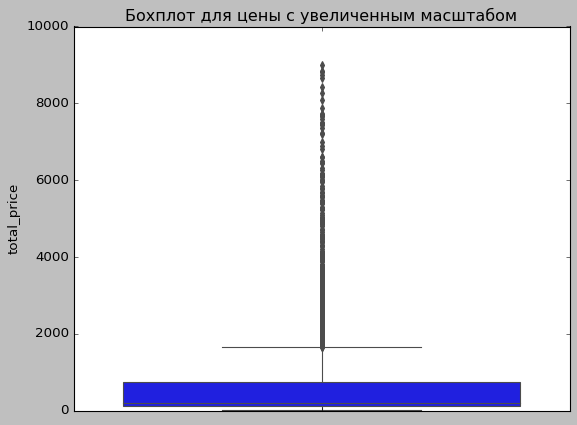

In [21]:
ax = sns.boxplot(y='total_price', data=data)
ax.set_ylim(0, 10000)
plt.title('Бохплот для цены с увеличенным масштабом')
plt.show()

Удалим все заказы с ценой выше 8000.

In [22]:
data = data.query('total_price < 8000')

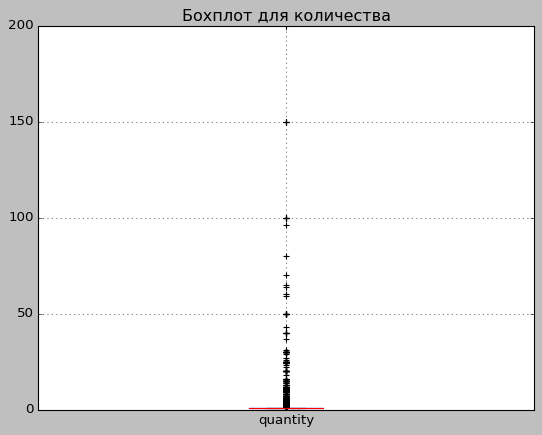

In [23]:
data.boxplot(column=['quantity'])
plt.title('Бохплот для количества')
plt.show()

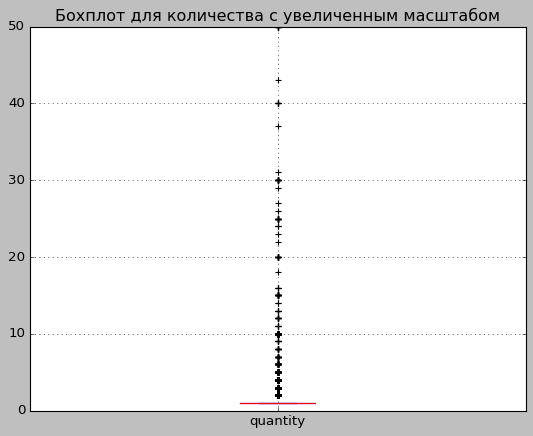

In [24]:
ax = data.boxplot(column=['quantity'])
ax.set_ylim(0, 50)
plt.title('Бохплот для количества с увеличенным масштабом')
plt.show()

Удалим все товары с кол-вом больше 30.

In [25]:
data = data.query('quantity < 30')

In [26]:
# посмотрим на размер датасета после удаления дубликатов и выбросов
data.shape

(4801, 8)

#### Выводы
<a id="conclusion_preprocessing"></a> 

Мы рассмотрели общую информацию о таблице и заметили:
 - у нас нет пропусков,
 - создали столбцы с датой и общей суммой заказа,
 - удалили выбросы и неявные дубликаты.

### Анализ данных
<a id="data_analysis"></a> 

In [27]:
def data_group(df, par, agg_par, agg_col):
    '''
    Функция группировки датасета
    Параметры:
    df -- датасет
    par -- название столбцов по которым идет группировка (str или list(str))
    agg_par -- словарь с названием столбца - ключ и названием агрегирующей функции - значение
    agg_col -- новое название агрегиррованных столбцов
    Возвращаемое значение:
    сгруппированный датасет
    '''
    data_gr = (
        df
       .groupby(by = par)
       .agg(agg_par)
    )
    data_gr.columns = agg_col
    return data_gr.sort_values(by = agg_col[0], ascending=False).reset_index()

In [28]:
def plotting_bar(x, y, df, title, title_x, title_y, hue=None, 
                 figsize=(8, 5), size_title=18, size_axis=15, size_label=10, ylim=None, xlim=None):
    '''
    Функция для построение барплота
    Параметры:
    x -- значения по оси x
    y -- значения по оси y
    df -- датасет
    title -- загаловок графика
    title_x -- заголовок оси x
    title_y -- заголовок оси y
    hue -- значение для группировки по этому столбцу
    figsize -- размер графика
    size_title -- размер шрифта заголовка графика
    size_axis -- размер шрифта заголовков осей
    size_label -- размер шрифта подписей осей
    ylim -- ограничение оси y
    xlim -- ограничение оси x
    Возвращаемое значение:
    None
    '''
    sns.set_palette('pastel') 
    plt.figure(figsize=figsize)
    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)
    sns.barplot(x=x, y=y, data=df, hue=hue)
    plt.title(title, fontsize=size_title)
    plt.xlabel(title_x, fontsize=size_axis)
    plt.xticks(rotation=-45)
    plt.ylabel(title_y, fontsize=size_axis)
    plt.tick_params (axis='both', which='major', labelsize=size_label)
    plt.show()

#### Определение среднего количества товаров в заказе
<a id="data_analysis_average_number_of_items_in_order"></a> 

In [29]:
data_order = data_group(data, 'order_id', 
                        {'customer_id': 'nunique', 'quantity': 'sum', 
                         'price': 'median', 'total_price': 'sum'}, 
                        ['cnt_customer', 'total_number_of_products', 'avg_price', 'total_price'])
data_order.head()

,order_id,cnt_customer,total_number_of_products,avg_price,total_price
0,71480,3,3,74.00,222.00
1,69485,3,3,1274.00,3635.00
2,69310,2,14,59.00,826.00
3,71226,2,2,569.00,1138.00
4,71663,2,2,134.00,268.00


In [30]:
cnt_customer = data_order.query('cnt_customer > 1')['order_id']
print(f'{cnt_customer.count()} заказа, которые совершили больше одного пользователей ')

27 заказа, которые совершили больше одного пользователей 


У нас есть 27 заказов, которые совершили больше одного пользователя, но один заказ - один пользователь, поэтому удалим такие заказы и посмотрим на размер полученного датасета.

In [31]:
orders = data_order.query('cnt_customer > 1')['order_id'].tolist()
data = data.query('order_id not in @orders')
data.shape

(4741, 8)

In [32]:
data_order.describe()

,order_id,cnt_customer,total_number_of_products,avg_price,total_price
count,2721.00,2721.00,2721.00,2721.00,2721.00
mean,64511.21,1.01,3.21,771.34,1091.60
std,17684.08,0.11,5.43,1099.66,1325.75
min,12624.00,1.00,1.00,11.50,14.00
25%,69104.00,1.00,1.00,134.00,280.00
50%,70446.00,1.00,1.00,352.00,674.00
75%,71855.00,1.00,3.00,974.00,1373.00
max,73164.00,3.00,60.00,7724.00,22056.00


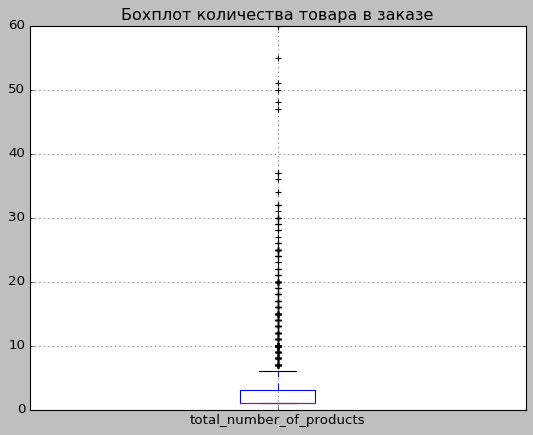

In [33]:
data_order.boxplot(column=['total_number_of_products'])
plt.title('Бохплот количества товара в заказе')
plt.show()

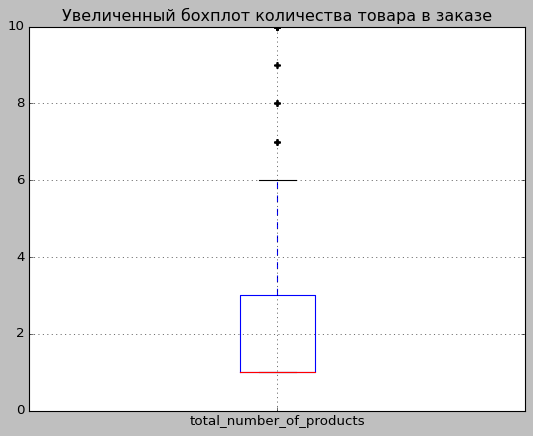

In [34]:
data_order.boxplot(column=['total_number_of_products'])
plt.title('Увеличенный бохплот количества товара в заказе')
plt.ylim(0, 10)
plt.show()

Максимальное количество товара в заказе - 60, а минимальное - 3. Больше 6 заказов - аномалия.

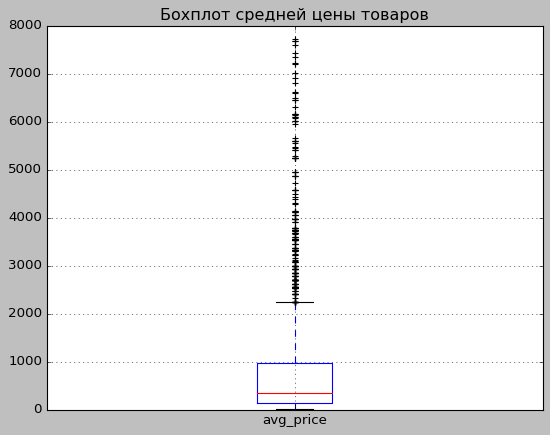

In [35]:
data_order.boxplot(column=['avg_price'])
plt.title('Бохплот средней цены товаров')
plt.show()

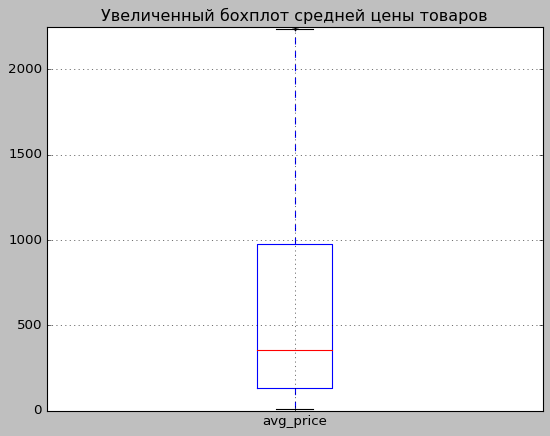

In [36]:
data_order.boxplot(column=['avg_price'])
plt.title('Увеличенный бохплот средней цены товаров')
plt.ylim(0, 2250)
plt.show()

Максимальное значение средней цены товара - 7724, а минимальное - 11.5. Заказы со средней ценой выше 2250 - аномалия.

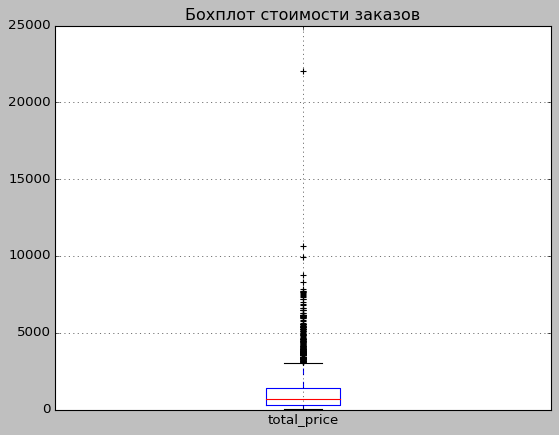

In [37]:
data_order.boxplot(column=['total_price'])
plt.title('Бохплот стоимости заказов')
plt.show()

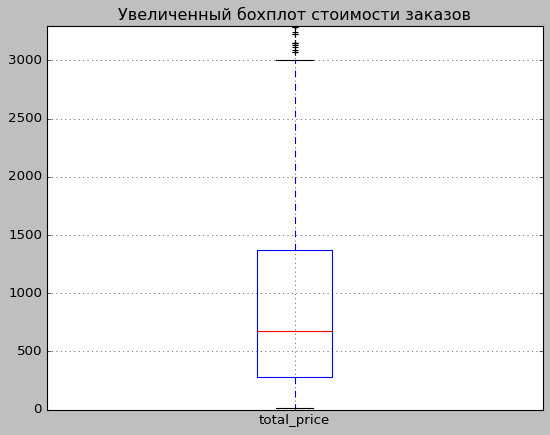

In [38]:
data_order.boxplot(column=['total_price'])
plt.title('Увеличенный бохплот стоимости заказов')
plt.ylim(0, 3300)
plt.show()

Максимальная стоимость заказа - 22056, а минимальная - 1091. Заказы со стоимостью выше 3000 - аномалия.

#### Определение среднего чека общего, по временам года
<a id="data_analysis_average_check"></a> 

In [39]:
def determine_time_of_year(date_year_month):
    '''
    Функция для определения времени года
    Параметры:
    date_year_month -- дата заказа
    Возвращаемое значение:
    время года
    '''
    month = date_year_month.month
    seasons = {
        '1': 'зима',
        '2': 'зима',
        '3': 'весна',
        '4': 'весна',
        '5': 'весна',
        '6': 'лето',
        '7': 'лето',
        '8': 'лето',
        '9': 'осень',
        '10': 'осень',
        '11': 'осень',
        '12': 'зима',
    }
    season = seasons.get(str(month), 'не удалось определить')
    return season

Сначала определим время года заказа по его дате. 

In [40]:
data['season'] = data['date_year_month'].apply(determine_time_of_year)
data.head()

,date,customer_id,order_id,product,quantity,price,date_year_month,total_price,season
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.00,2018-10-01,142.00,осень
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.00,2018-10-01,194.00,осень
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.00,2018-10-01,112.00,осень
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.00,2018-10-01,179.00,осень
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.00,2018-10-01,112.00,осень


In [41]:
# сгруппируем данные по времени года и определим кол-во уникальных пользователей, количество заказов,
# общее колв-во купленного товара, среднюю цену товара и выручку за сезон
data_season = data_group(data, 'season', 
                        {'customer_id': 'nunique', 'order_id': 'nunique', 
                         'quantity': 'sum', 'total_price': ['median', 'sum']}, 
                        ['cnt_customer', 'cnt_orders', 'total_number_of_products', 
                         'avg_price', 'total_price'])
data_season

,season,cnt_customer,cnt_orders,total_number_of_products,avg_price,total_price
0,осень,678,798,2459,280.00,965625.00
1,весна,601,667,3083,135.00,707058.00
2,зима,600,710,1638,478.50,721081.00
3,лето,488,521,1451,224.50,540775.00


In [42]:
# определим кол-во уникальных пользователей, количество заказов,
# общее колв-во купленного товара, среднюю цену товара и выручку за все время
data.agg({'customer_id': 'nunique', 'order_id': 'nunique', 
          'quantity': 'sum', 'total_price': ['median', 'sum'], 
          'date_year_month': ['max', 'min']})

,customer_id,order_id,quantity,total_price,date_year_month
nunique,2345.00,2694.00,NaN,NaN,NaT
sum,NaN,NaN,8631.00,2934539.00,NaT
median,NaN,NaN,NaN,188.00,NaT
max,NaN,NaN,NaN,NaN,2019-10-01
min,NaN,NaN,NaN,NaN,2018-10-01


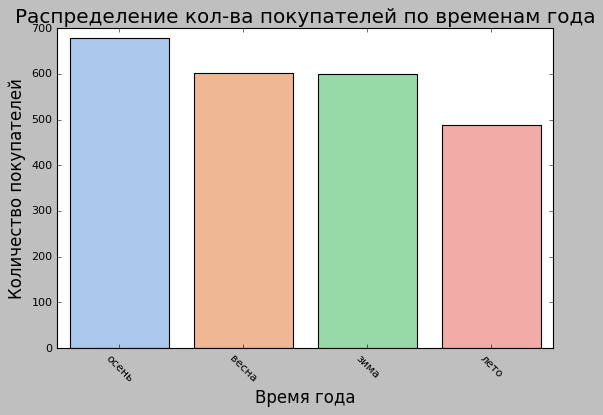

In [43]:
# график cnt_customer
plotting_bar('season', 'cnt_customer', data_season, 
             'Распределение кол-ва покупателей по временам года', 
             'Время года', 'Количество покупателей')

Осенью больше всего было покупателей, меньше всего летом, весной и зимой покупателей было примерно одинаково. Возможно это связано с тем, что летом люди уезжают на дачу и в отпуск, а осенью возвращаются в город.

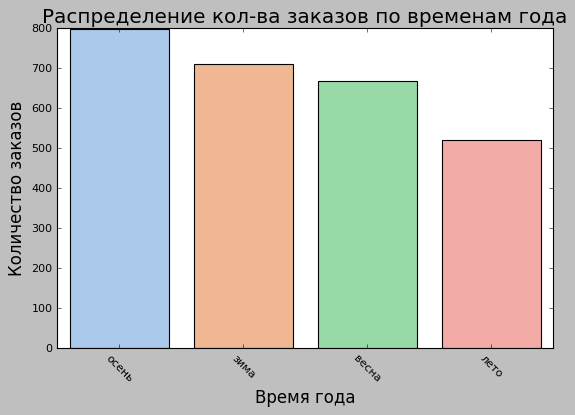

In [44]:
# график cnt_orders
plotting_bar('season', 'cnt_orders', data_season.sort_values(by='cnt_orders', ascending=False), 
             'Распределение кол-ва заказов по временам года', 
             'Время года', 'Количество заказов')

Количество заказов максимально также осенью, а минимально летом как и кол-во покупателей. Но зимой кол-во заказов чуть выше, чем весной, хотя кол-во клиентов в эти сезоны одинаковое. Т.е.нельзя сказать о прямой зависимости кол-ва покупателей и кол-ва заказов.

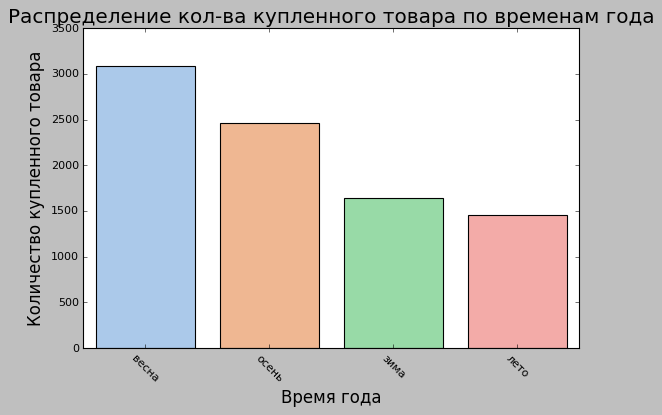

In [45]:
# график total_number_of_products
plotting_bar('season', 'total_number_of_products', 
             data_season.sort_values(by='total_number_of_products', ascending=False), 
             'Распределение кол-ва купленного товара по временам года', 
             'Время года', 'Количество купленного товара')

Весной больше всего покупают товаров, меньше всего летом. Возможно это связано с началом дачного сезона и закупкой рассады, семян и прочего товара для дачи.

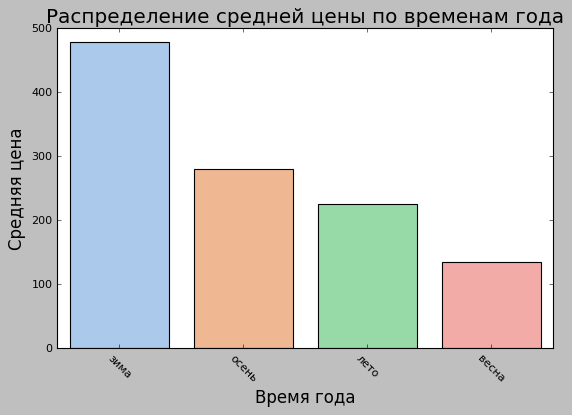

In [46]:
# график avg_price
plotting_bar('season', 'avg_price', data_season.sort_values(by='avg_price', ascending=False), 
             'Распределение средней цены по временам года', 
             'Время года', 'Средняя цена')

Средняя цена за все время - 188, осенью и летом средняя цена чуть выше, весной средняя цена ниже средней цены за год, а зимой почти в два раза выше.

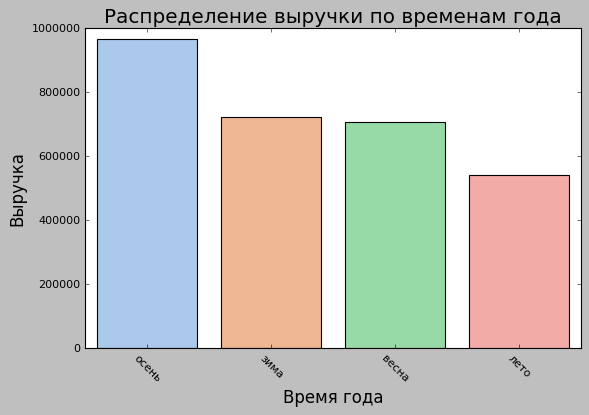

In [47]:
# график total_price
plotting_bar('season', 'total_price', data_season.sort_values(by='total_price', ascending=False), 
             'Распределение выручки по временам года', 
             'Время года', 'Выручка')

Максимальная выручка - осенью, а минимальня летом.

#### Определение категорий товаров
<a id="data_analysis_product_categories"></a> 

In [48]:
def assigning_category(product):
    '''
    Функция для определения категории товара
    Параметры:
    product -- категория товара
    Возвращаемое значение:
    category - категория товара
    '''
    categories = {'растения': ['растение', 'цветок', 'радермахера', 'хризолидокарпус', 'циперус', 
                               'лузеана', 'юкка', 'рассада', 'герань', 'пеларгония', 'суккулент', 
                               'эхеверия', 'эвкалипт', 'адиантум', 'кампанула', 'нолина', 'калатея',
                               'цикламен', 'кориандр', 'мирт', 'хлорофитум', 'глоксиния', 'азалия',
                               'гортензия', 'хризантема', 'иссоп', 'сантолина', 'аспарагус', 'муррайя',
                               'афеляндра', 'антуриум', 'молодило', 'фиалка', 'гербера', 'душица',
                               'мелисса', 'роза', 'бегония', 'розмарин', 'альбука', 'бальзамин', 'бадан',
                               'полынь', 'лаванда', 'мята', 'каланхое', 'примула', 'дендробиум', 'кофе',
                               'калоцефалус', 'каллуна', 'капсикум', 'мимоза', 'соланум', 'бархатцы', 
                               'космея', 'морковь', 'настурция', 'огурец', 'петуния', 'крассула', 
                               'алиссум', 'гвоздика', 'годеция', 'календула', 'кореопсис', 'флокс',
                               'цинерария', 'эшшольция', 'фаленопсис', 'лапчатка', 'подсолнечник',
                               'пуансетия', 'гиностемма', 'ель', 'кипарисовик', 'аптения', 'пуансеттия',
                               'скиммия', 'фиттония', 'тимьян', 'алоэ вера', 'спатифиллум', 'фикус',
                               'кодонанта', 'гимнокалициум', 'кактус', 'крокусы', 'гипсофила', 'калла',
                               'эпипремнум', 'гиацинты?', 'аквилегия', 'базилик', 'горох', 'земляника',
                               'седум', 'томат', 'укроп', 'тюльпаны?', 'незабудка', 'нефролепис', 
                               'декабрист', 'калибрахоа', 'чабер', 'калибрахоа', 'ранункулус', 'лавр',
                               'овсянница', 'георгина', 'смолевка', 'цинния', 'вербейник', 'виола',
                               'колокольчик', 'котовник', 'эхинацея', 'ясколка', 'лилейник', 'мускари',
                               'папоротник', 'энотера', 'вербена', 'фуксия', 'цитрофортунелла', 'осина',
                               'пеперомия', 'платикодон', 'дыня', 'гардения', 'лобелия', 'пиретрум',
                               'вероника', 'капуста', 'арбуз', 'баклажан', 'клубника', 'патиссон', 
                               'виноград', 'джункус', 'драцена', 'фатсия', 'хоста', 'гайлардия', 
                               'монарда', 'ромашка', 'рудбекия', 'барвинок', 'сциндапсус', 'трав[аы]',
                               'астра', 'бузульник', 'камнеломка', 'солидаго', 'физостегия', 'лантана',
                               'лен небесная лазурь', 'буддлея', 'анемона', 'лаватера', 'змееголовник',
                               'валериана', 'любисток', 'петрушка', 'шалфей', 'лилиа', 'табак', 'пахира',
                               'кабачок', 'тыква', 'зверобой', 'клен', 'импатиенс', 'хамедорея', 
                               'замиокулькас', 'мединилла', 'амариллис', 'салат', 'шеффлера', 'литопс'],
                  'товары для ванной': ['таз', 'сушилка', 'корзина', '[её]рш', 'дозатор', 'в ванную?',
                                        '(?:доска|гладильная)(?: доска| гладильная)', 'для ванны?о?й?', 
                                        'мыло', 'зубная паста', 'держатель для туалетной бумаги', 'фен',
                                        'мыльница', 'ванна', 'паста зубная', 'увлажняющая маска'],
                  'товары для кухни': ['сковород[аы]', 'кастрюля', 'тарелка', 'вилка', 'ложка', 'котел',
                                       'нож', 'круже?ка?', 'фужеро?в?', 'кувшин', 'масленка',
                                       'толкушка', 'чайник', 'банка', 'противень', 'миксер', 'салфетница',
                                       'чайный набор', 'салатник', 'стакан', '(?:овоще|рыбо)(?:чистка)',
                                       '(?:овоще|манто|паро|соко)(?:варка|выжималка)', 'терка', 'лопатка',  
                                       'лоток для холодца', 'бокал', 'для выпечки', 'скребок кондитерский',
                                       'картофелемялка', 'формы? для кексов', 'пресс для чеснока',
                                       'столовых приборов', 'термос', 'блюдц[еа]', 'электроштопор',
                                       'доска разделочная', 'бульонница', 'разделочная доска', 'кухонные',
                                       'емкость для соуса', 'весы настольные', 'хлебница', 'скалка', 
                                       'емкость для свч', 'орехоколка', 'тортница', 'блюдо', 'бидон',
                                       'посуд[аы]', 'миска', 'сотейник', 'шприц кондитерский', 'сито',
                                       'венчик',  'сахарница', 'половник', 'кипятильник'],
                  'товары для дома': ['стяжка', 'пружин[ыа]', 'стремянк[аи]', 'петля', 'свере?ло?',
                                      'карниз', 'светильнико?в?', 'утюг', 'шнур', 'сварка', 'ковш',
                                      'угольник', 'линейка', 'термометр', 'бензин', 'шило', 'шпагат',
                                      'весы напольные', 'рассекатель пламени', 'подголовник', 'сиденье',
                                      'инструмент', 'кольц[ао] для штор', 'фоторамка', 'ручка-скоба',
                                      'сменный блок для ролика', 'для глажения', 'фал капроновый',  
                                      'штангенциркуль', 'напильник', 'фиксатор-шар', 'пуф', 'веревка',
                                      'насадка на валик', 'завертка', 'уголок оконный', 'пьезозажигалка',
                                      'решетка вентиляционная', 'стяжки', 'шпингалет', 
                                      'основание для пробки'],
                  'сумки и чехлы': ['сумка', 'тележка', 'чехол'],
                  'товары для интерьера': ['муляж', '(?:декоративная|искусственная)(?: композиция)?', 
                                           'искусственная лиана', 'кашпо', 'искусственный лист', 
                                           'ваза'],
                  'текстиль': ['коврик', 'плед', 'ков[её]р', 'простыня', 'штор[аы]', 'полотене?це?', 
                               'салфето?ка?', 'скатерть', 'наматрасник', 'подрукавник', 'халат', 
                               'одеяло', 'подушка', 'ткань', 'наматрацник', 'наволочка', 'покрывало',
                               'рукав для гладильной доски', 'пододеяльник', 
                               'мешок для деликатной стирки', 'покрытие для гладильной доски'],
                  'товары для уборки': ['щетка', 'веник', 'швабр[ыае]', 'порошок', 'урна', 'корыто', 
                                        'чистящ[иеа][ейя]', 'сметка', 'антижир', 'губка', 'пылесос',
                                        'ополаскиватель', 'налет', 'вантуз', 'для ведра', 'ведро',
                                        'соль для посудомоечных машин', 'против засоров', 'насадка-моп',
                                        '(?:перчатки )(?:латексные|резиновые|[ a-zA-z]+ из латекса)', 
                                        'скребок для окон','окномойка', 'тряпка', 'совок', 'защита для рук',
                                        '(?:для )(?:чистки|полировки|удаления|мусора|мытья|тряпки)'],
                  'хранение и вешалки': ['вешало?к[иа]?', 'крючок', 'прищепо?к[аи]?', 'плечики', 
                                         'контейнер', 'ящик', 'коробк?а?', 'для хранения', 'кофр', 
                                         'комод', 'подставка', 'этажерка', 'полк[аи]', 'ключница',
                                         'обувница', 'стеллаж', 'корзинка', 'лоток']
                 }
    for category, patterns_category in categories.items():
        pattern = '|'.join(patterns_category)
        if re.findall(fr'{pattern}', product):
            return category
    return 'не определена'

In [49]:
data['category'] = data['product'].apply(assigning_category)
shape_category_not_defined = data.query('category == "не определена"').shape[0]
print(f'{shape_category_not_defined} - кол-во строк, у которых неопределена категория')

0 - кол-во строк, у которых неопределена категория


In [50]:
data_category = data_group(data, 'category', 
                           {'product': 'count', 'customer_id': 'nunique', 'order_id': 'nunique', 
                            'quantity': 'sum', 'price': 'median', 'total_price': 'sum'}, 
                           ['cnt', 'cnt_customer', 'cnt_order', 'total_number_of_products', 
                            'avg_price', 'total_price'])
data_category

,category,cnt,cnt_customer,cnt_order,total_number_of_products,avg_price,total_price
0,растения,3001,1071,1226,4870,134.00,900748.00
1,сумки и чехлы,422,357,410,479,1068.50,690414.00
2,товары для ванной,373,306,348,609,899.00,475843.00
3,товары для кухни,278,221,239,699,202.00,187073.00
4,текстиль,187,162,176,471,434.00,208822.00
5,товары для интерьера,141,79,86,554,59.00,43903.00
6,хранение и вешалки,134,114,121,490,389.00,174132.00
7,товары для уборки,104,86,93,208,441.50,114078.00
8,товары для дома,101,86,95,251,899.00,139526.00


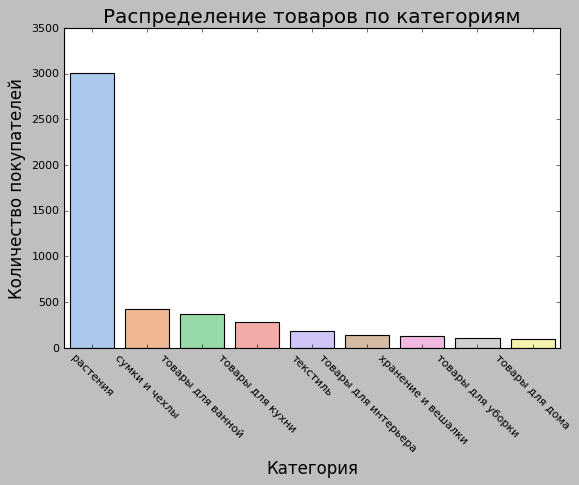

In [51]:
plotting_bar('category', 'cnt', data_category, 
             'Распределение товаров по категориям', 
             'Категория', 'Количество покупателей')

Больше всего товаров в категории растений, их существенно больше, чем в других категориях. Меньше всего товаров в категории товаров для дома, больше в категории сумки и чехлы.

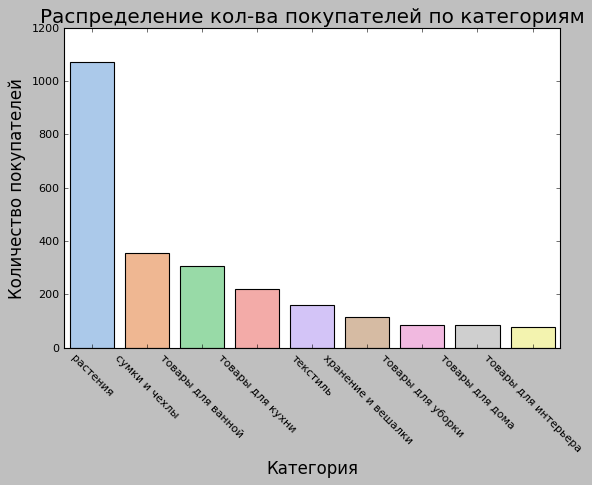

In [52]:
plotting_bar('category', 'cnt_customer', data_category.sort_values(by='cnt_customer', ascending=False), 
             'Распределение кол-ва покупателей по категориям', 
             'Категория', 'Количество покупателей')

Т.к. в группе растений намного больше товаров, чем в остальных, то не будем учитывать эту категорию. Больше всего покупателей выбирает сумки и чехлы, меньше всего товары для интерьера.

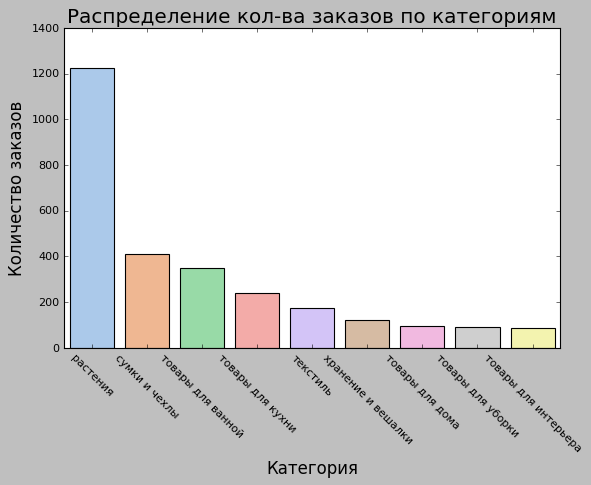

In [53]:
plotting_bar('category', 'cnt_order', 
             data_category.sort_values(by='cnt_order', ascending=False), 
             'Распределение кол-ва заказов по категориям', 
             'Категория', 'Количество заказов')

Количество заказов распределено также как и количество покупателей по категориям, т.е.между количеством покупателей и количеством заказов по категориям есть прямая связь.

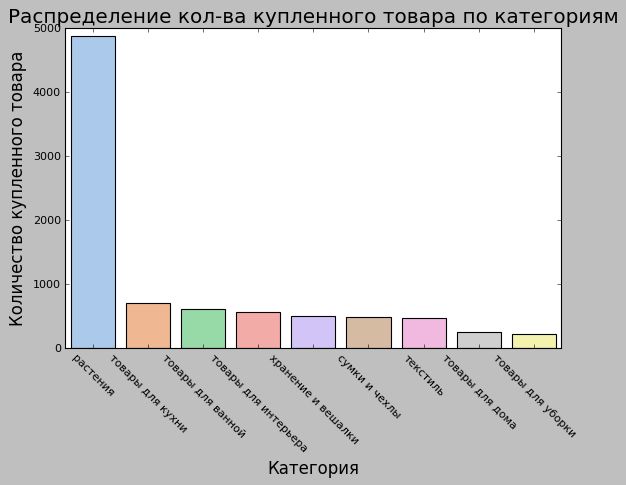

In [54]:
plotting_bar('category', 'total_number_of_products', 
             data_category.sort_values(by='total_number_of_products', ascending=False), 
             'Распределение кол-ва купленного товара по категориям', 
             'Категория', 'Количество купленного товара')

Больше всего покупают товары для кухни и для ванной, меньше всего покупают товары для уборки и для дома.

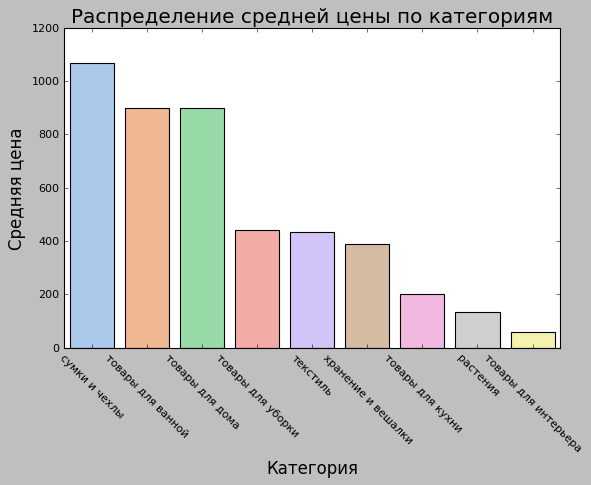

In [55]:
plotting_bar('category', 'avg_price', 
             data_category.sort_values(by='avg_price', ascending=False), 
             'Распределение средней цены по категориям', 
             'Категория', 'Средняя цена')

Хотя товаров в категории растений больше всего средняя цена в этой категории почти самая маленькая. Самы дорогие товары в категории сумки и чехлы, в категориях товары для ванной и для дома одинаковая, самые дешевые товары в категории товаров для интерьера. Сумки и чехлы - самая дорогая категория из-за чусок тележек, которые дорогие.

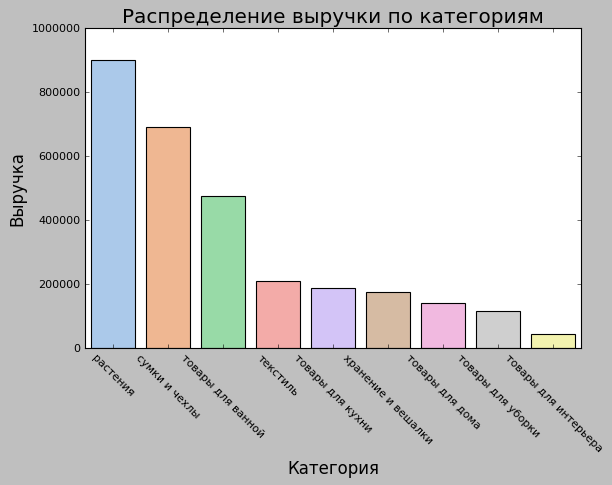

In [56]:
plotting_bar('category', 'total_price', 
             data_category.sort_values(by='total_price', ascending=False), 
             'Распределение выручки по категориям', 
             'Категория', 'Выручка')

Больше всего выручка от товаров категории сумки и чехлы, потом товары для ванны, меньше всего выручка от категории товаров для интерьера.

#### Определение сезонности товаров
<a id="data_analysis_seasonality_of_goods"></a> 

In [57]:
data_season_category = data_group(data, ['season', 'category'], 
                                  {'category': 'count'}, ['cnt_category'])
data_season_category.head()

,season,category,cnt_category
0,весна,растения,1498
1,осень,растения,599
2,лето,растения,517
3,зима,растения,387
4,осень,товары для ванной,153


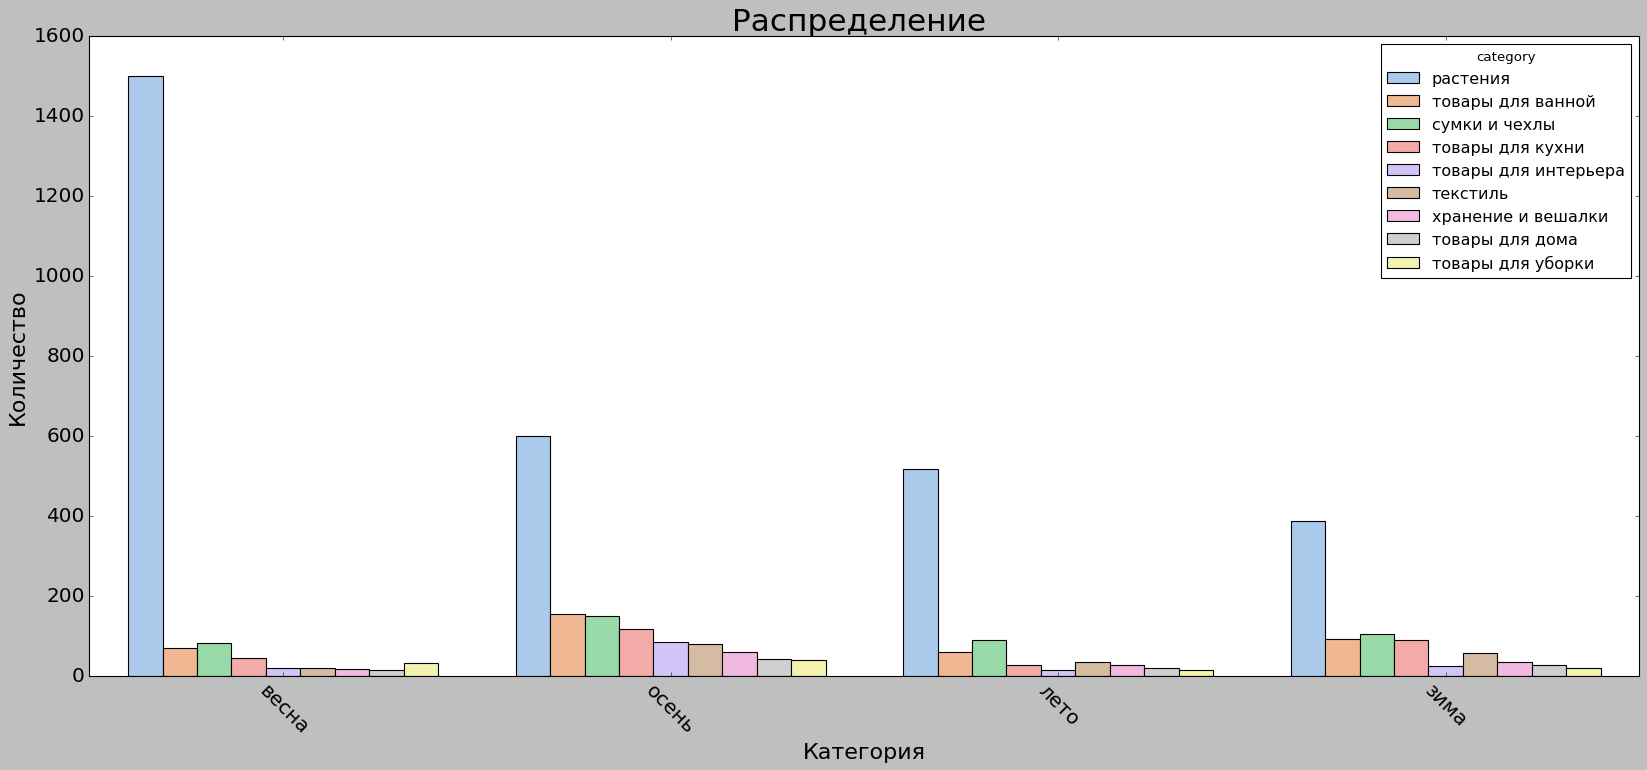

In [58]:
plotting_bar('season', 'cnt_category', 
             data_season_category, 
             'Распределение ', 
             'Категория', 'Количество', 'category', (25,10), 28, 20, 18)

Весной, летом и зимой самая популярная категория - сумки и чехлы, осенью - товары для ванной. Весной самая непопулярная категория - товары для дома, осенью, летом и зимой - товары для уборки.

#### Определение самых популярных товаров
<a id="data_analysis_most_popular_products"></a> 

In [59]:
def clear_data(pr):
    '''
    Функция для "очистки" названия товара
    Параметры:
    pr -- название товара
    Возвращаемое значение:
    pr - очищенное название товара
    '''
    pr = re.sub(r'(?:\d+[хx]\d+[- ]?)+(?: ?с?м)?', '', pr)
    pr = re.sub(r'(?:d|h|диам\.)(?:[-\s]?=? ?\d+,?)+(?:\s?с?м|\s?шт)?', '', pr)
    pr = re.sub(r'(?:кассета\sпо\s)?(?:[-\s]?\d+,?)+(?:\s?с?м|\s?шт)', '', pr)
    pr = re.sub(r'(?:объем\s)?(?:\d+,?\d+)+(?: ?м?л)', '', pr)
    pr = re.sub(r',+', ',', pr)
    return pr.strip(' ').strip(',')

In [60]:
data['product_clear'] = data['product'].apply(clear_data)
data['product_cut'] = data['product_clear'].apply(lambda x: ' '.join(x.split()[0:1]))
data.head()

,date,customer_id,order_id,product,quantity,price,date_year_month,total_price,season,category,product_clear,product_cut
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.00,2018-10-01,142.00,осень,растения,комнатное растение в горшке алое вера,комнатное
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.00,2018-10-01,194.00,осень,растения,комнатное растение в горшке кофе арабика,комнатное
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.00,2018-10-01,112.00,осень,растения,радермахера,радермахера
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.00,2018-10-01,179.00,осень,растения,хризолидокарпус лутесценс,хризолидокарпус
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.00,2018-10-01,112.00,осень,растения,циперус зумула,циперус


In [61]:
data_group(data, 'product_cut', {'order_id': 'nunique'}, ['cnt_order']).head(10)

,product_cut,cnt_order
0,пеларгония,269
1,сушилка,263
2,сумка-тележка,226
3,гладильная,118
4,коврик,98
5,тележка,95
6,рассада,92
7,муляж,86
8,чехол,83
9,штора,72


In [62]:
data.query('product_cut == "гладильная"').head()

,date,customer_id,order_id,product,quantity,price,date_year_month,total_price,season,category,product_clear,product_cut
125,2018100716,cf971740-da80-41a6-acfb-ef934cede4b4,68556,гладильная доска gimi jean green line 107х30 см,1,1349.00,2018-10-01,1349.00,осень,товары для ванной,гладильная доска gimi jean green line,гладильная
237,2018101316,8ae705c9-7448-4ad9-8115-7f29e72012b5,68631,гладильная доска ника верона 1 чехол одри 122х42 см дв1о,1,1949.00,2018-10-01,1949.00,осень,товары для ванной,гладильная доска ника верона 1 чехол одри дв1о,гладильная
315,2018101912,d0dd6df3-b3e5-486b-a0ce-c03f02092395,68691,гладильная доска ника haushalt m hm 122х40 см,1,1499.00,2018-10-01,1499.00,осень,товары для ванной,гладильная доска ника haushalt m hm,гладильная
337,2018102015,2d2fe40b-3a7c-4172-94d2-a7a7c7030266,68701,"гладильная доска дсп ""бэлль-юниор2"", 112*34,5, бю2, ника",1,749.00,2018-10-01,749.00,осень,товары для ванной,"гладильная доска дсп ""бэлль-юниор2"", 112*34,5, бю2, ника",гладильная
344,2018102108,83581792-1bc2-49f7-983c-a87b921ab1cb,68707,гладильная доска sarayli orion 130x44 см,1,2999.00,2018-10-01,2999.00,осень,товары для ванной,гладильная доска sarayli orion,гладильная


Сымый популярный товар - пеларгония, его покупали 269 раз, в топ 10 также входят сушилки, сумки-тележки, гладильная	доска, коврик, тележка, рассада, муляж, чехол, штора.

#### Выводы
<a id="conclusion_data_analysis"></a>

Мы удалили заказы,которые совершили больше одного пользователя. Максимальное количество товара в заказе - 60, а минимальное - 3. Больше 6 заказов - аномалия. Максимальная стоимость заказа - 22056, а минимальная - 1091. Заказы со стоимостью выше 3000 - аномалия.

Осенью больше всего было покупателей, меньше всего летом, весной и зимой покупателей было примерно одинаково. Возможно это связано с тем, что летом люди уезжают на дачу и в отпуск, а осенью возвращаются в город.
Количество заказов максимально также осенью, а минимально летом как и кол-во покупателей. Но зимой кол-во заказов чуть выше, чем весной, хотя кол-во клиентов в эти сезоны одинаковое. Т.е.нельзя сказать о прямой зависимости кол-ва покупателей и кол-ва заказов.
Весной больше всего покупают товаров, меньше всего летом. Возможно это связано с началом дачного сезона и закупкой рассады, семян и прочего товара для дачи.
Средняя цена за все время - 188, осенью и летом средняя цена чуть выше, весной средняя цена ниже средней цены за год, а зимой почти в два раза выше.
Максимальная выручка - осенью, а минимальня летом.

Мы выделили 9 категорий товаров. Больше всего товаров в категории растений, их существенно больше, чем в других категориях. Меньше всего товаров в категории товаров для дома, больше в категории сумки и чехлы.
Т.к. в группе растений намного больше товаров, чем в остальных, то не будем учитывать эту категорию. Больше всего покупателей выбирает сумки и чехлы, меньше всего товары для интерьера.
Количество заказов распределено также как и количество покупателей по категориям, т.е.между количеством покупателей и количеством заказов по категориям есть прямая связь.
Больше всего покупают товары для кухни и для ванной, меньше всего покупают товары для уборки и для дома.
Хотя товаров в категории растений больше всего средняя цена в этой категории почти самая маленькая. Самы дорогие товары в категории сумки и чехлы, в категориях товароы для ванной и для дома одинаковая, самые дешевые товары в категории товаров для интерьера. Сумки и чехлы - самая дорогая категория из-за чусок тележек, которые дорогие.
Больше всего выручка от товаров категории сумки и чехлы, потом товары для ванны, меньше всего выручка от категории товаров для интерьера.

Весной, летом и зимой самая популярная категория - сумки и чехлы, осенью - товары для ванной. Весной самая непопулярная категория - товары для дома, осенью, летом и зимой - товары для уборки.

Сымый популярный товар - пеларгония, его покупали 269 раз, в топ 10 также входят сушилки, сумки-тележки, гладильная доска, коврик, тележка, рассада, муляж, чехол, штора.

### Кластеризация пользователей
<a id="clustering_of_users"></a> 

Для начала сгруппируем данные по покупателю, чтобы каждый покупатель был только в одном кластере.

In [63]:
data_clustering = data_group(data, 'customer_id', 
                             {'quantity': 'sum', 'total_price': 'median'},
                             ['total_number_of_products', 'total_avg_price'])

In [64]:
X = data_clustering.drop(['customer_id'], axis=1)
sc = StandardScaler()
x_sc = sc.fit_transform(X)

Построим дендограмму для определения количества кластеров.

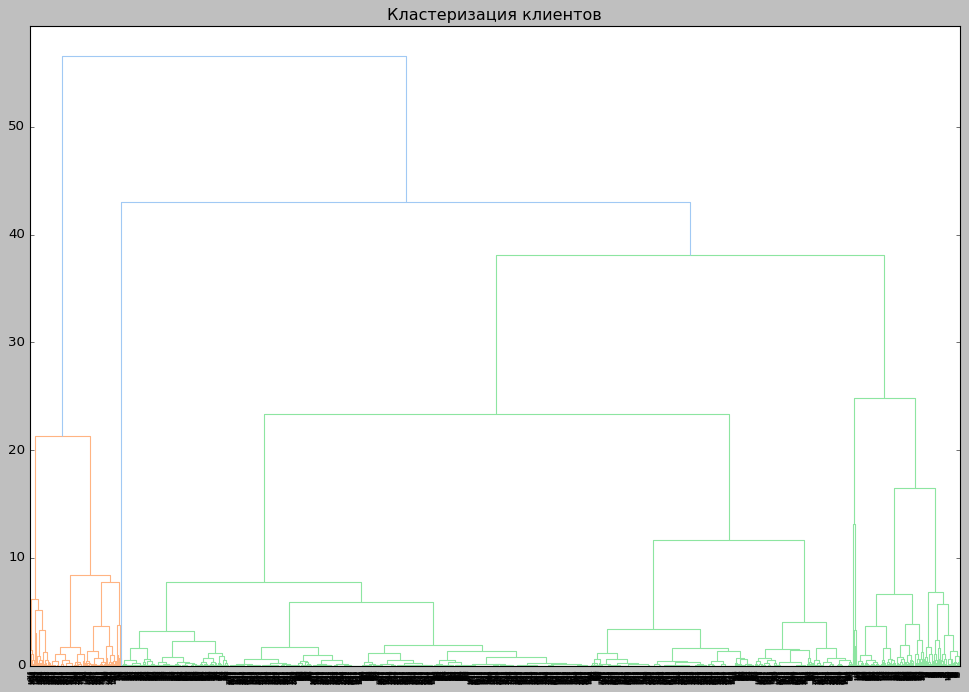

In [65]:
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show()

На дендограмме три цвета, поэтму оптимальное кол-во кластеров - 3.

In [66]:
km = KMeans(n_clusters=3, random_state=0)
labels = km.fit_predict(x_sc)
data_clustering['cluster_km'] = labels
data_clustering.head()

,customer_id,total_number_of_products,total_avg_price,cluster_km
0,c971fb21-d54c-4134-938f-16b62ee86d3b,270,723.00,2
1,4d93d3f6-8b24-403b-a74b-f5173e40d7db,142,824.00,2
2,b7b865ab-0735-407f-8d0c-31f74d2806cc,68,177.00,0
3,97f94402-66c0-4995-b8d7-adb33eda71c8,64,190.00,0
4,2a0acc09-e343-4f92-b5c0-f598ef2b07d4,60,76.00,0


In [67]:
data_with_cluster = data.merge(data_clustering, on='customer_id')
data_with_cluster.head()

,date,customer_id,order_id,product,quantity,price,date_year_month,total_price,season,category,product_clear,product_cut,total_number_of_products,total_avg_price,cluster_km
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.00,2018-10-01,142.00,осень,растения,комнатное растение в горшке алое вера,комнатное,7,142.00,0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.00,2018-10-01,194.00,осень,растения,комнатное растение в горшке кофе арабика,комнатное,7,142.00,0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.00,2018-10-01,112.00,осень,растения,радермахера,радермахера,7,142.00,0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.00,2018-10-01,179.00,осень,растения,хризолидокарпус лутесценс,хризолидокарпус,7,142.00,0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.00,2018-10-01,112.00,осень,растения,циперус зумула,циперус,7,142.00,0


In [68]:
data_group(data_with_cluster, 'cluster_km',
                             {'customer_id': 'nunique', 'order_id': 'nunique', 
                              'total_number_of_products': 'sum', 'total_avg_price': ['median', 'sum']},
                             ['cnt_customer', 'cnt_order', 
                              'total_number_of_products', 'total_avg_price', 'total_price']
          )

,cluster_km,cnt_customer,cnt_order,total_number_of_products,total_avg_price,total_price
0,0,2092,2275,48103,164.00,1664832.00
1,1,251,262,696,3329.00,1000226.00
2,2,2,157,44162,723.00,136450.00


У нас получилось три кластера:
- 0 кластер с 2092 покупателями с 2275 заказами с 48103 товарами и средней ценой 164 рубля. Общая выручка этого кластера 1664832.
- 1 кластер с 251 покупателем с 262 заказами с 696 товарами и средней ценой 3329 рубля. Общая выручка этого кластера 1000226.
- 2 кластер с 2 покупателями со 157 заказами с 44162 товарами и средней ценой 723 рубля. Общая выручка этого кластера 136450.

In [69]:
data_clustering_season = data_group(data_with_cluster, ['cluster_km', 'season'],
                                   {'customer_id': ['nunique', 'count'], 'total_price': 'median',
                                   'order_id': 'nunique'},
                                   ['cnt_customer', 'cnt', 'total_avg_price', 'cnt_order'])
data_clustering_season.head()

,cluster_km,season,cnt_customer,cnt,total_avg_price,cnt_order
0,0,осень,599,1137,225.00,646
1,0,весна,541,1720,135.00,596
2,0,зима,538,692,381.00,571
3,0,лето,434,743,188.00,464
4,1,осень,77,82,3552.00,80


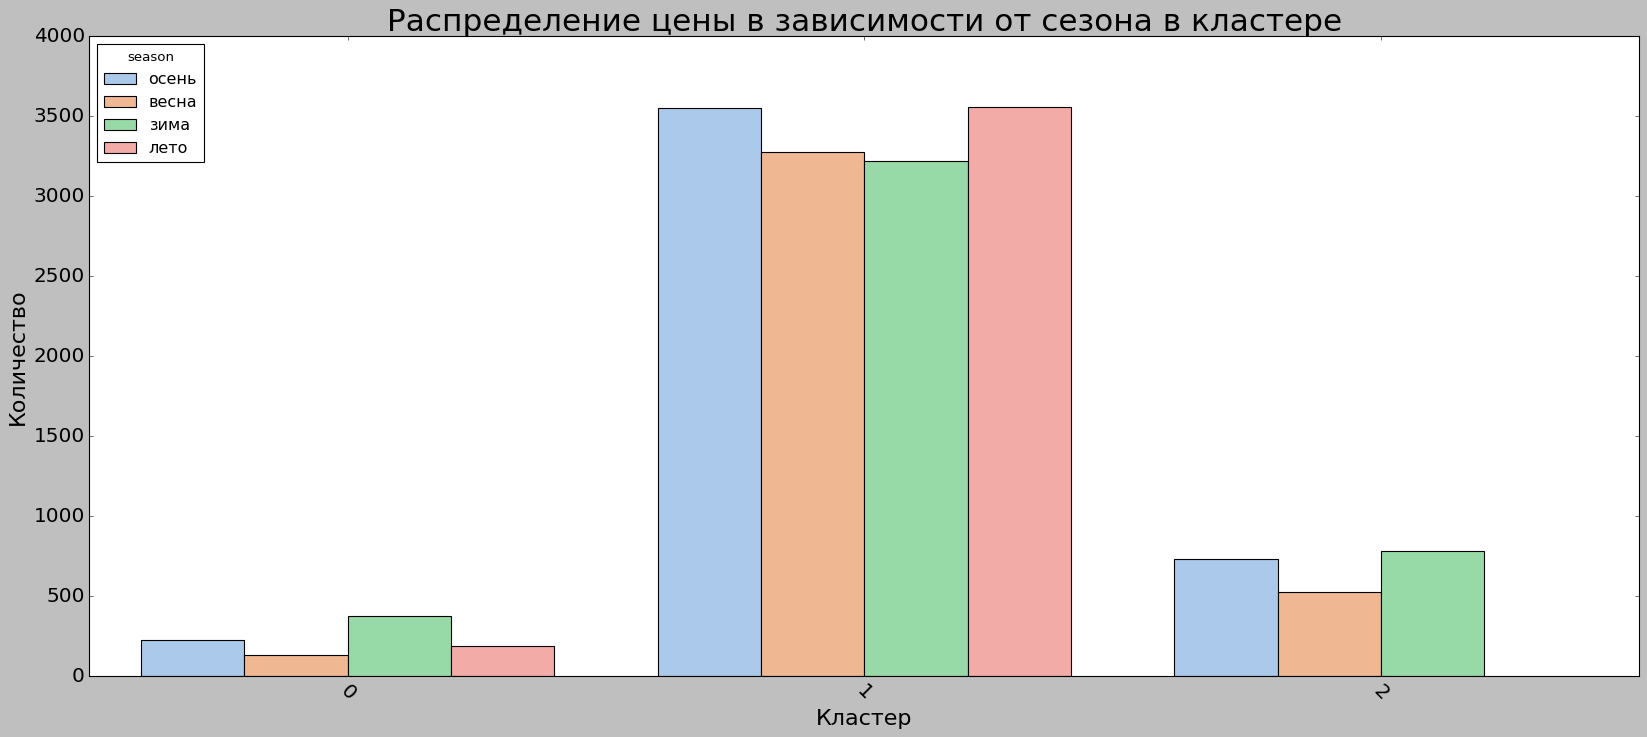

In [70]:
plotting_bar('cluster_km', 'total_avg_price', 
             data_clustering_season, 
             'Распределение цены в зависимости от сезона в кластере', 
             'Кластер', 'Количество', 'season', (25,10), 28, 20, 18)

В нулевом кластере больше всего покупатели тратят зимой, потом осенью, летом и весной. Летом и весной примерно одинаковая средняя стоимость заказа.

В первом кластере самая высокая средняя цена летом, осенью, зимой и летом. Зимой и летом примерно одинаковая средняя стоимость заказа.

Во втором кластере самая высокая средняя цена зимой, осенью и весной.

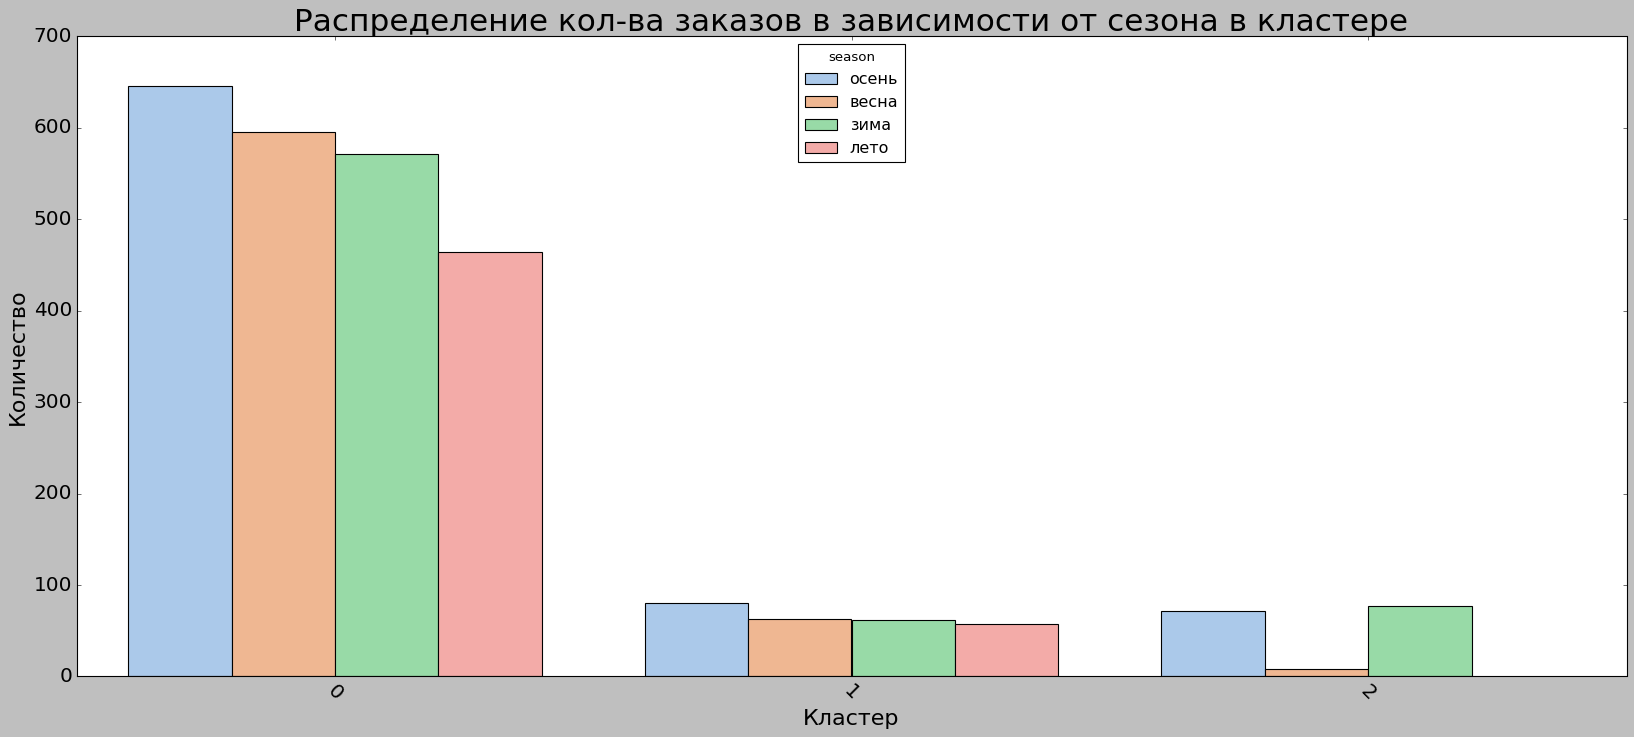

In [71]:
plotting_bar('cluster_km', 'cnt_order', 
             data_clustering_season, 
             'Распределение кол-ва заказов в зависимости от сезона в кластере', 
             'Кластер', 'Количество', 'season', (25,10), 28, 20, 18)

В нулевом кластере больше всего заказов осенью, потом весной, зиой и летом.

В первом кластере больше всего закаазов летом, весной, зимой и летом примерно одинаковое кол-во заказов.

Во втором кластере зимой и осенью примерно одинаковое кол-во закзаов, меньше весной.

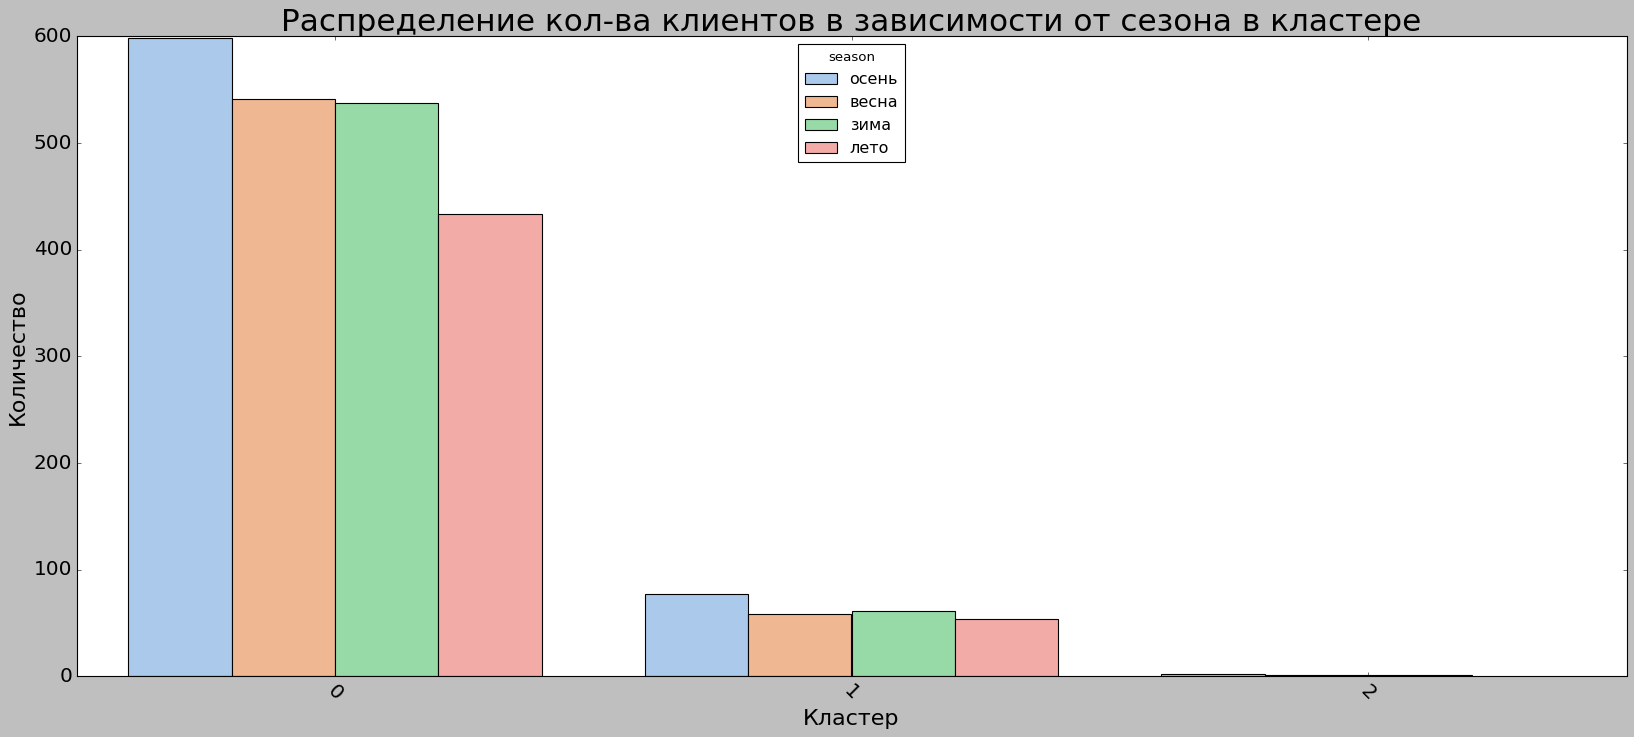

In [72]:
plotting_bar('cluster_km', 'cnt_customer', 
             data_clustering_season, 
             'Распределение кол-ва клиентов в зависимости от сезона в кластере', 
             'Кластер', 'Количество', 'season', (25,10), 28, 20, 18)

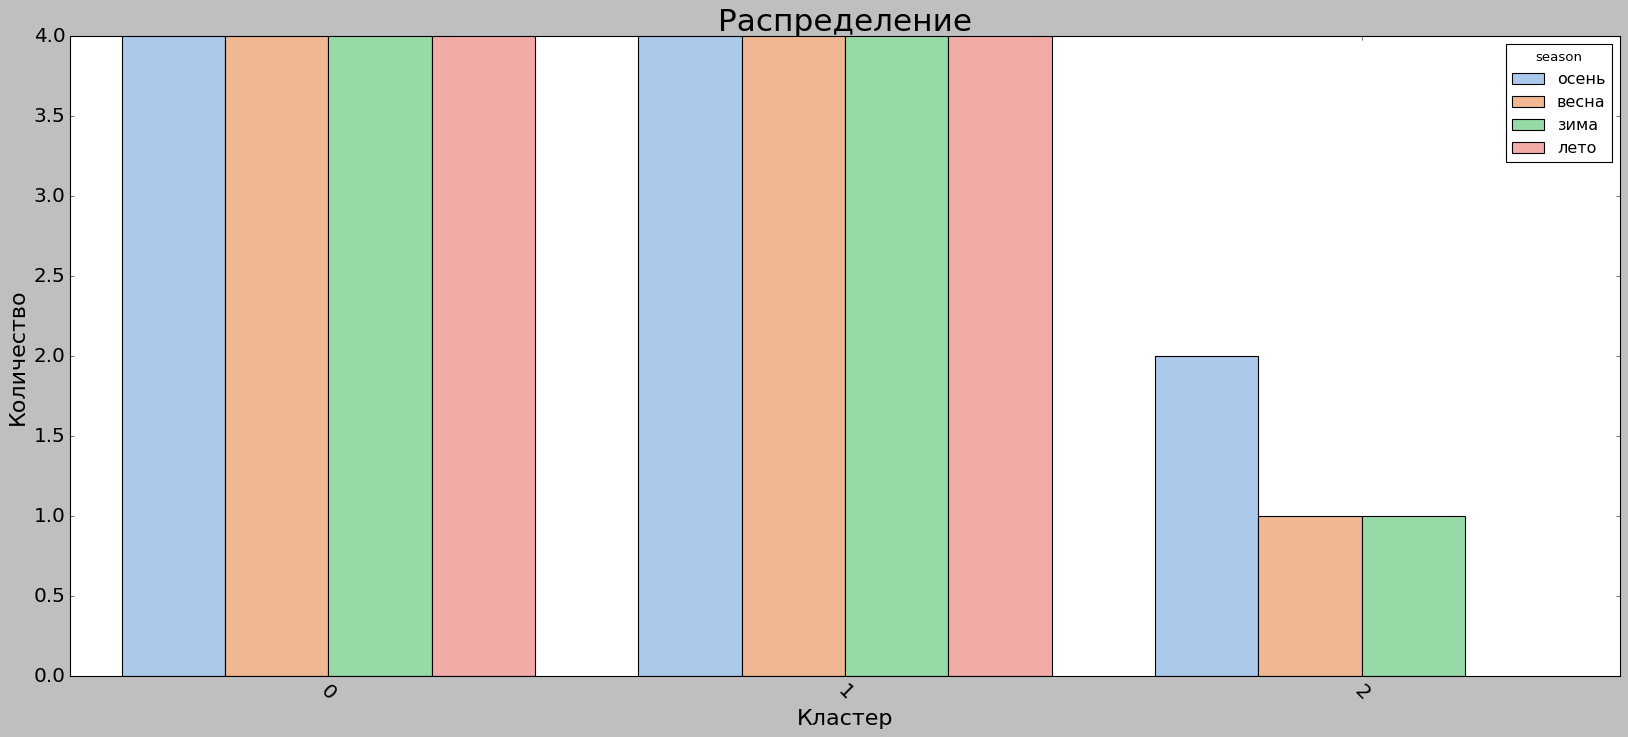

In [73]:
plotting_bar('cluster_km', 'cnt_customer', 
             data_clustering_season, 
             'Распределение', 
             'Кластер', 'Количество', 'season', (25,10), 28, 20, 18, (0, 4))

Во всех кластерах больше всего покупателей осенью, меньше всего летом. Как и общее распределение покупателей по сезонам. Во втором кластере нет клиентов летом.

In [74]:
data_clustering_category = data_group(data_with_cluster, ['cluster_km', 'category'],
                                   {'customer_id': ['nunique', 'count'], 'total_price': 'median', 
                                    'order_id': 'nunique'},
                                   ['cnt_customer', 'cnt', 'total_avg_price', 'cnt_order'])
data_clustering_category.head()

,cluster_km,category,cnt_customer,cnt,total_avg_price,cnt_order
0,0,растения,1036,2900,139.00,1134
1,0,сумки и чехлы,271,294,749.00,284
2,0,товары для ванной,249,284,677.00,262
3,0,товары для кухни,208,252,448.00,219
4,0,текстиль,144,159,637.00,148


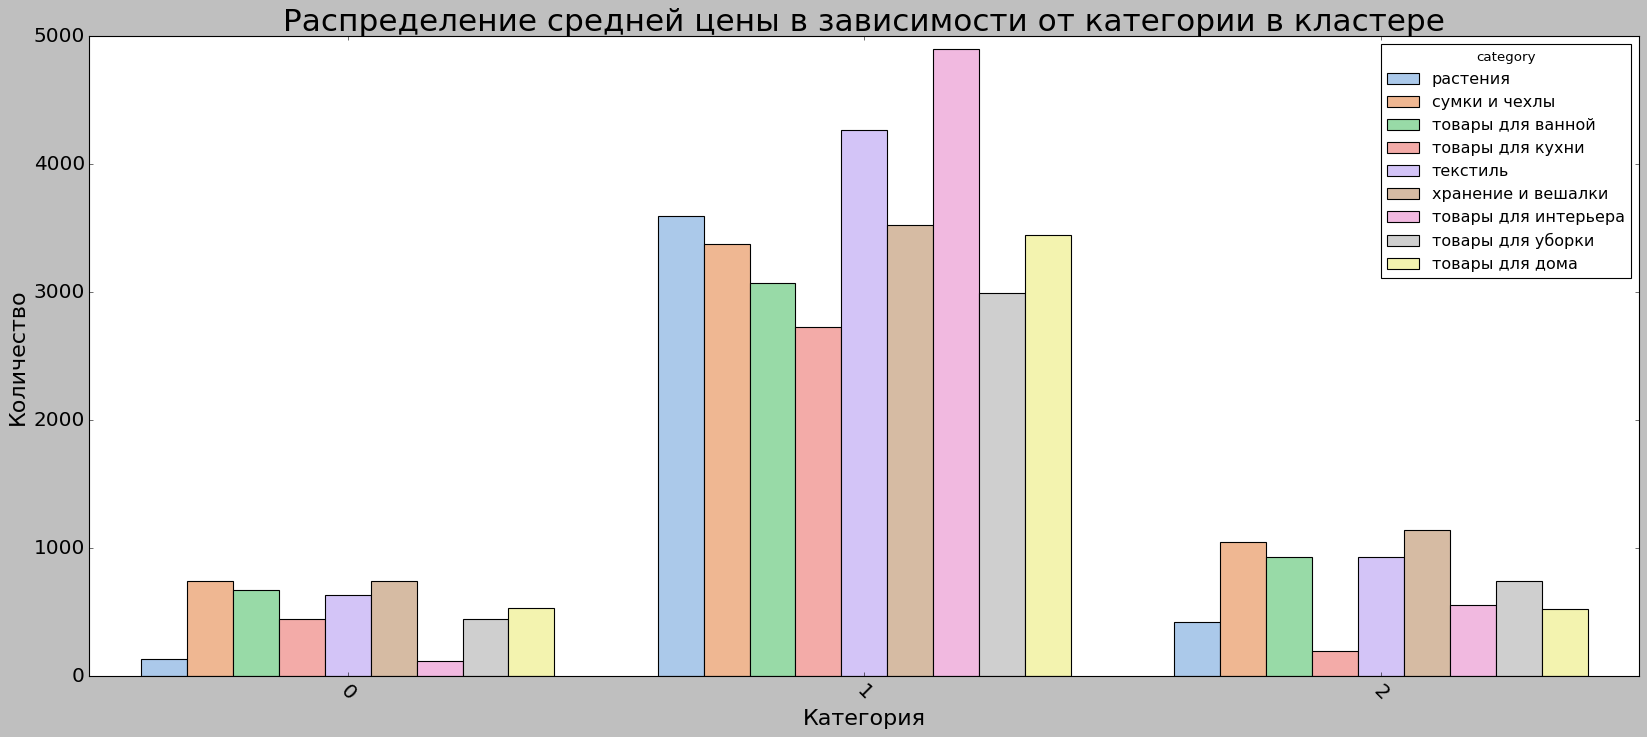

In [75]:
plotting_bar('cluster_km', 'total_avg_price', 
             data_clustering_category, 
             'Распределение средней цены в зависимости от категории в кластере', 
             'Категория', 'Количество', 'category', (25,10), 28, 20, 18)

В нулевом кластере самая высокая средняя стоимость заказа у категории сумки и чехлы, хранение и вешалки, товары для ванной, самая низкая у категорий растения и товары для интерьера.

В первом кластере самая высокая средняя цена у категории товары для интерьера, текстиль, растения, самая низкая цена у категорий товары для ванной, уборки и кухни.

В нулевом кластере самая высокая средняя цена у категории хранения и вешалки, сумки и чехлы, товары для ванной и текстиль, самая низкая цена у категорий товары для дома, растения и товары для интерьера. 


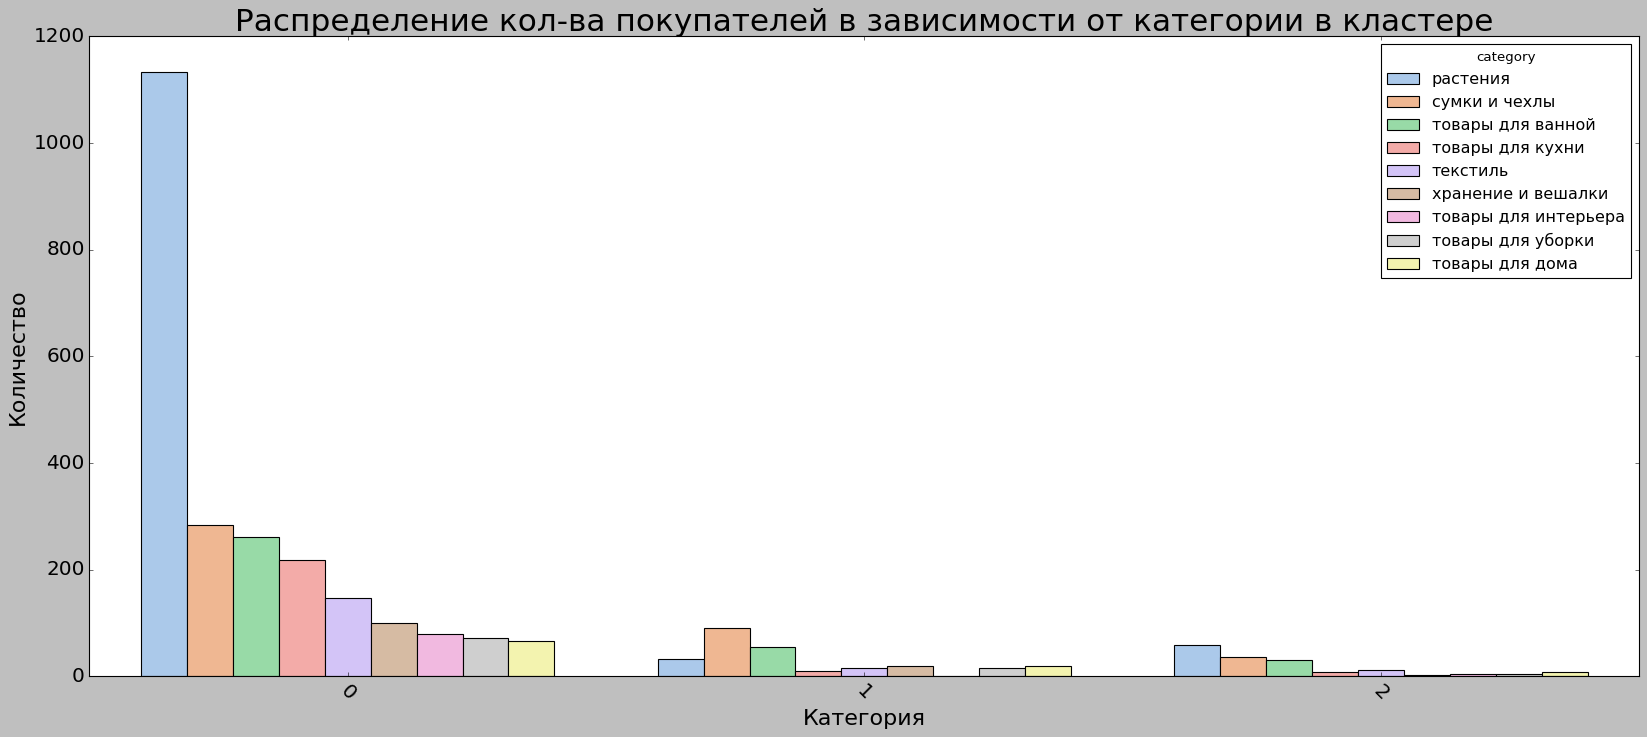

In [76]:
plotting_bar('cluster_km', 'cnt_order', 
             data_clustering_category, 
             'Распределение кол-ва покупателей в зависимости от категории в кластере', 
             'Категория', 'Количество', 'category', (25,10), 28, 20, 18)

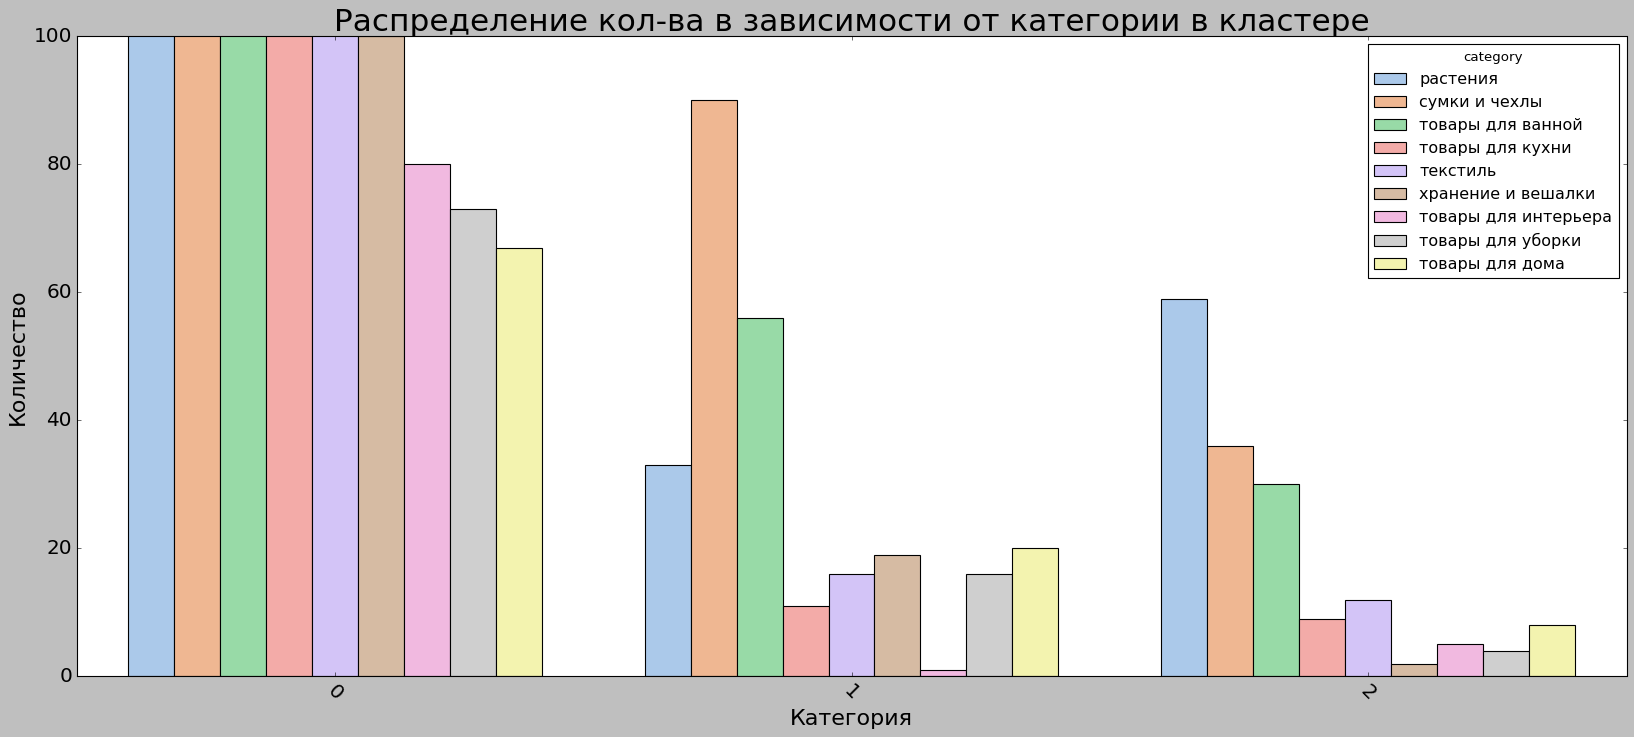

In [77]:
plotting_bar('cluster_km', 'cnt_order', 
             data_clustering_category, 
             'Распределение кол-ва в зависимости от категории в кластере', 
             'Категория', 'Количество', 'category', (25,10), 28, 20, 18, (0, 100))

В нулевом кластере больше всего заказов у категории растения (больше, чем в два раза), сумки и чехлы, товары для ванной, меньше всего у категорий товары для интерьера, уборки и дома.

В первом кластере больше всего заказов у категории сумки и чехлы, товары для ванной, меньше всего у категорий товары для интерьера.

В нулевом кластере больше всего заказов у категории растения, сумки и чехлы, товары для ванной, меньше всего у категорий хранение и вешалки.

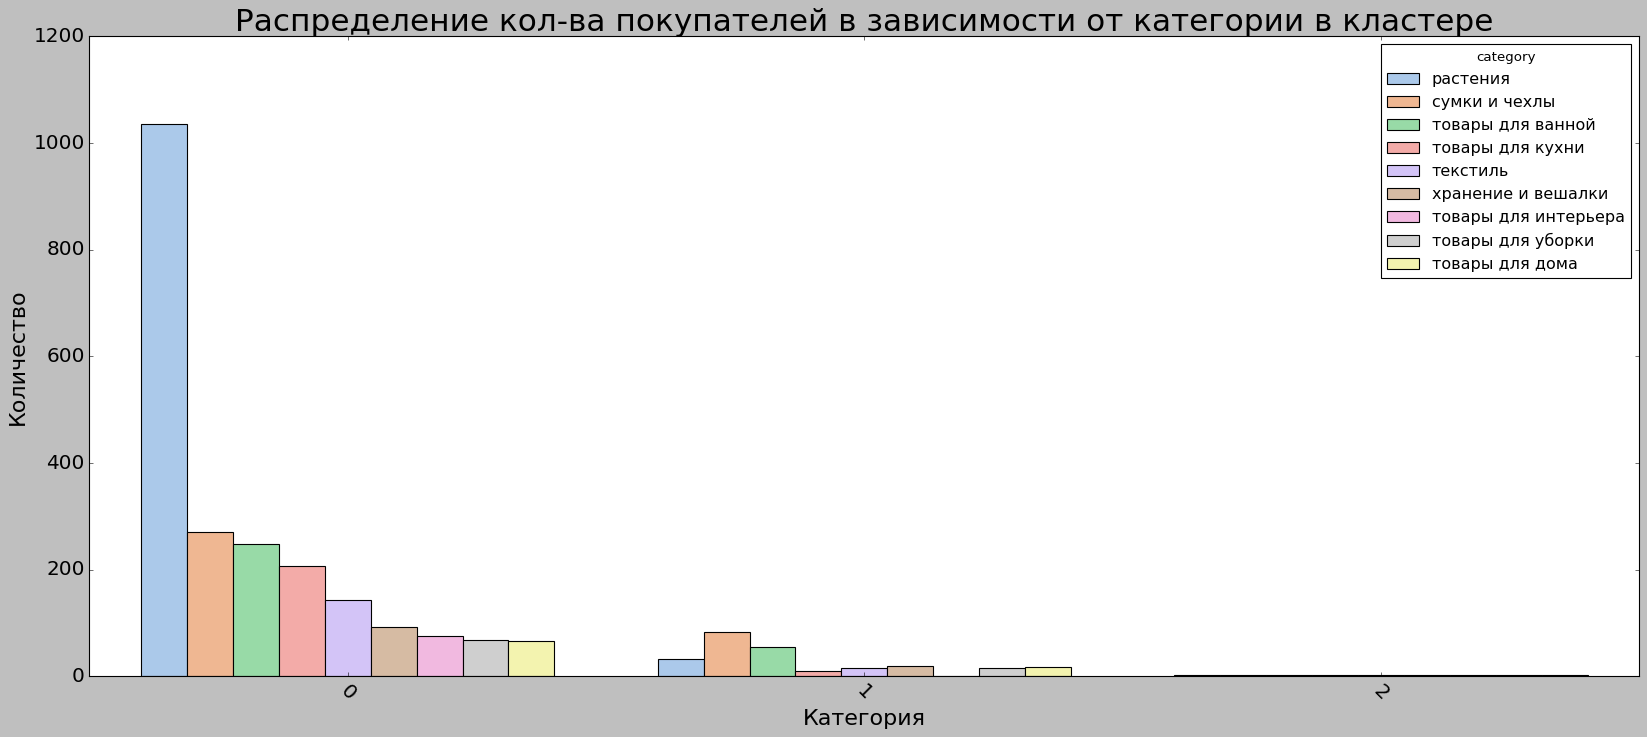

In [78]:
plotting_bar('cluster_km', 'cnt_customer', 
             data_clustering_category, 
             'Распределение кол-ва покупателей в зависимости от категории в кластере', 
             'Категория', 'Количество', 'category', (25,10), 28, 20, 18)

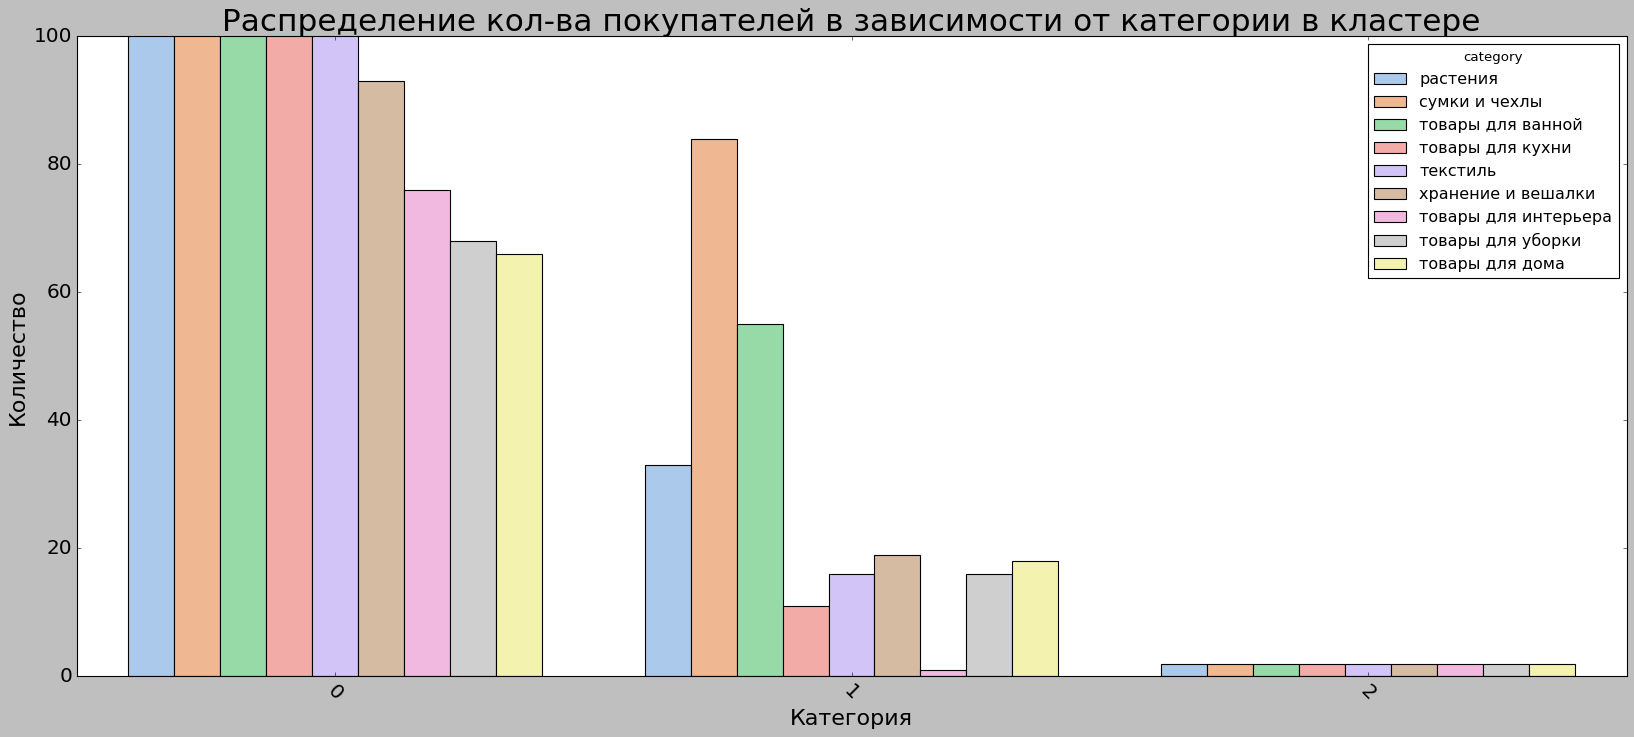

In [79]:
plotting_bar('cluster_km', 'cnt_customer', 
             data_clustering_category, 
             'Распределение кол-ва покупателей в зависимости от категории в кластере', 
             'Категория', 'Количество', 'category', (25,10), 28, 20, 18, (0, 100))

В нулевом кластере самая популярная категория - растения, ее больше почти в четыре раза выбирают, затем идут сумки и чехлы, товары для ванной, самые непопулярные категории - товары для интерьера, уборки и дома.

В первом кластере самая популярная категория - сумки и чехлы, потом товары для ванной, растения, самые непопулярные категории - товары для кухни, уборки, интерьера.

Во втором кластере все категории равнозначные с 2 клиентами.

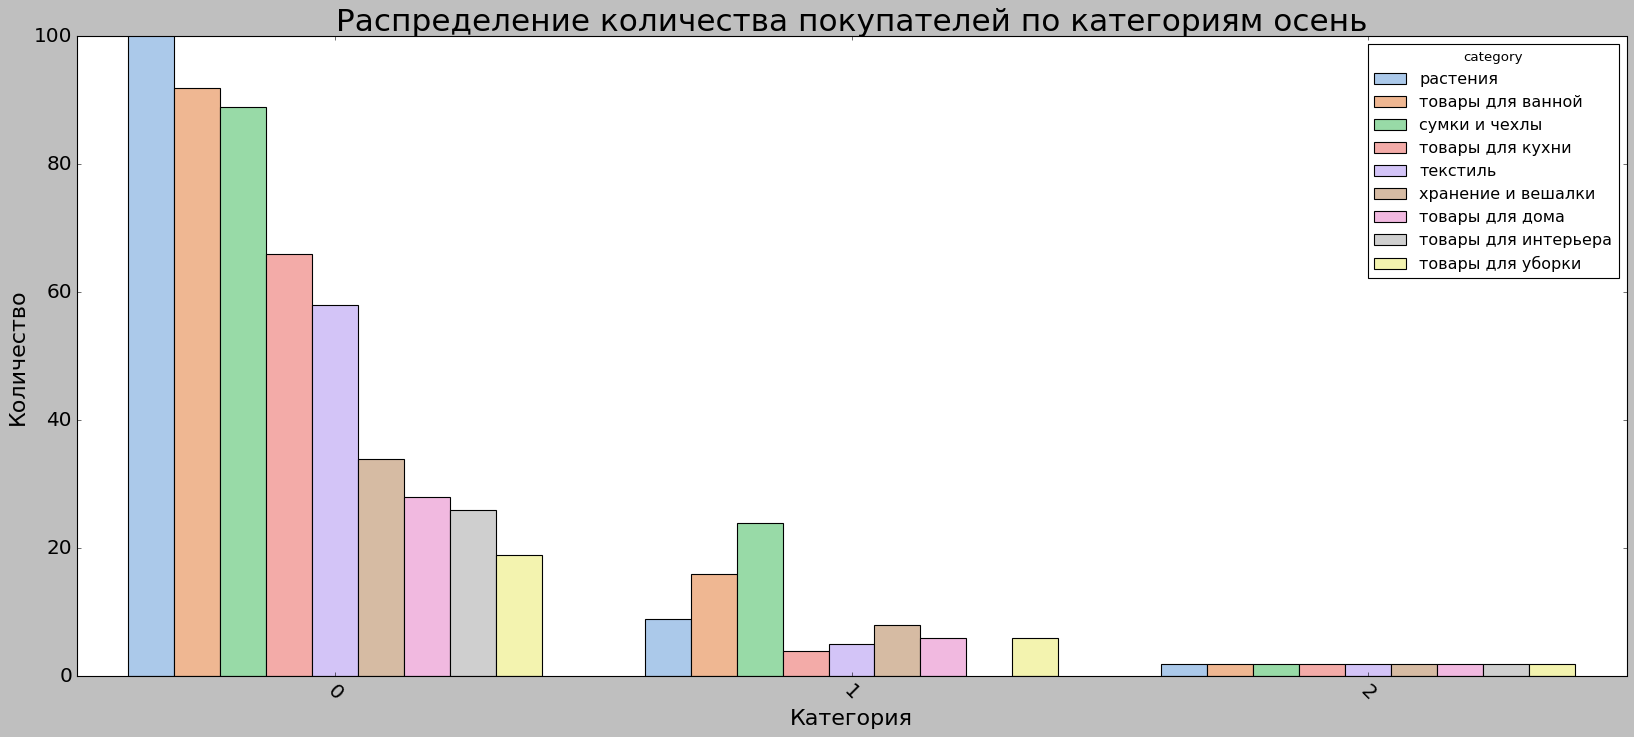

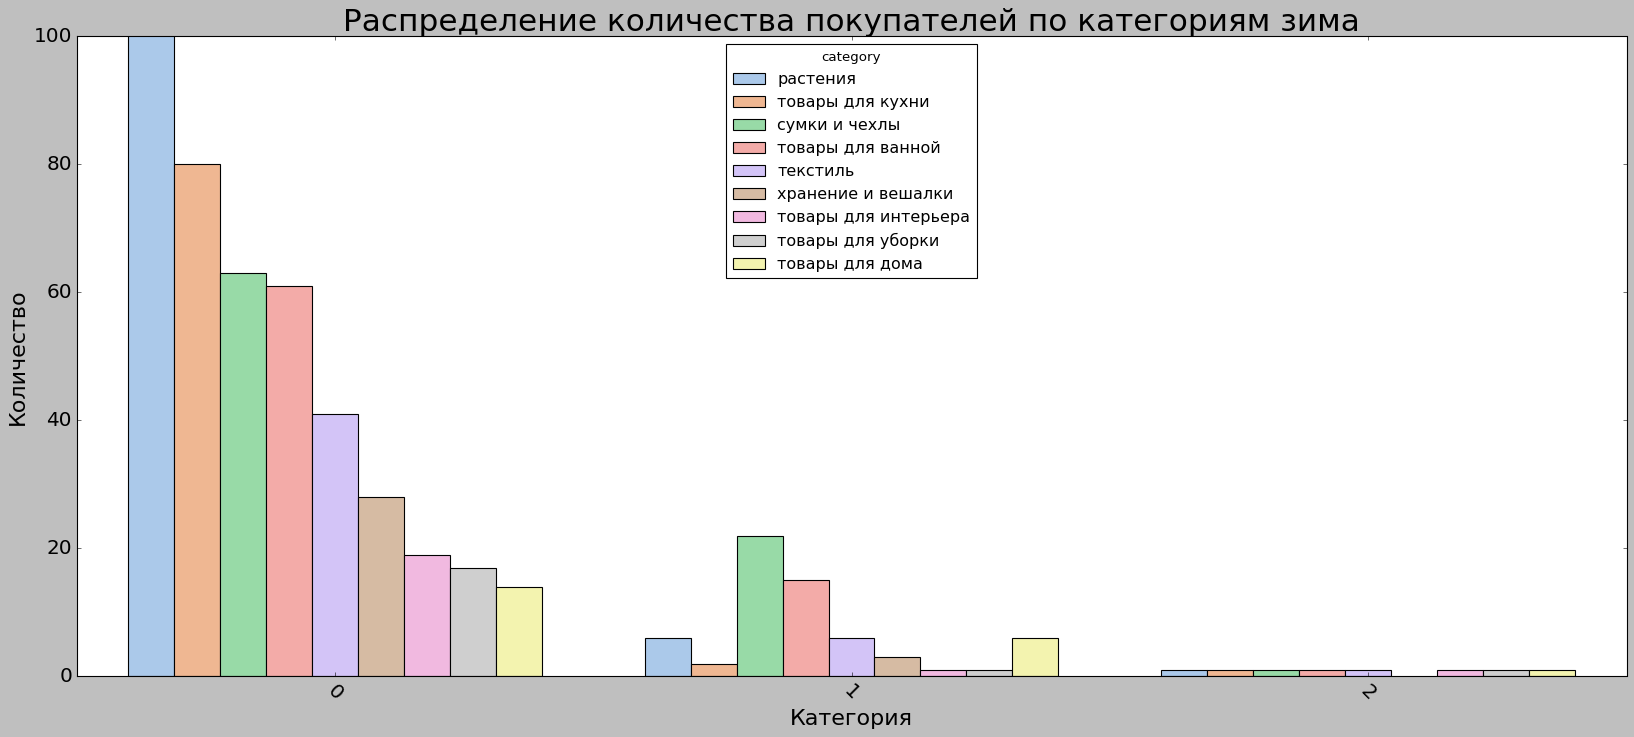

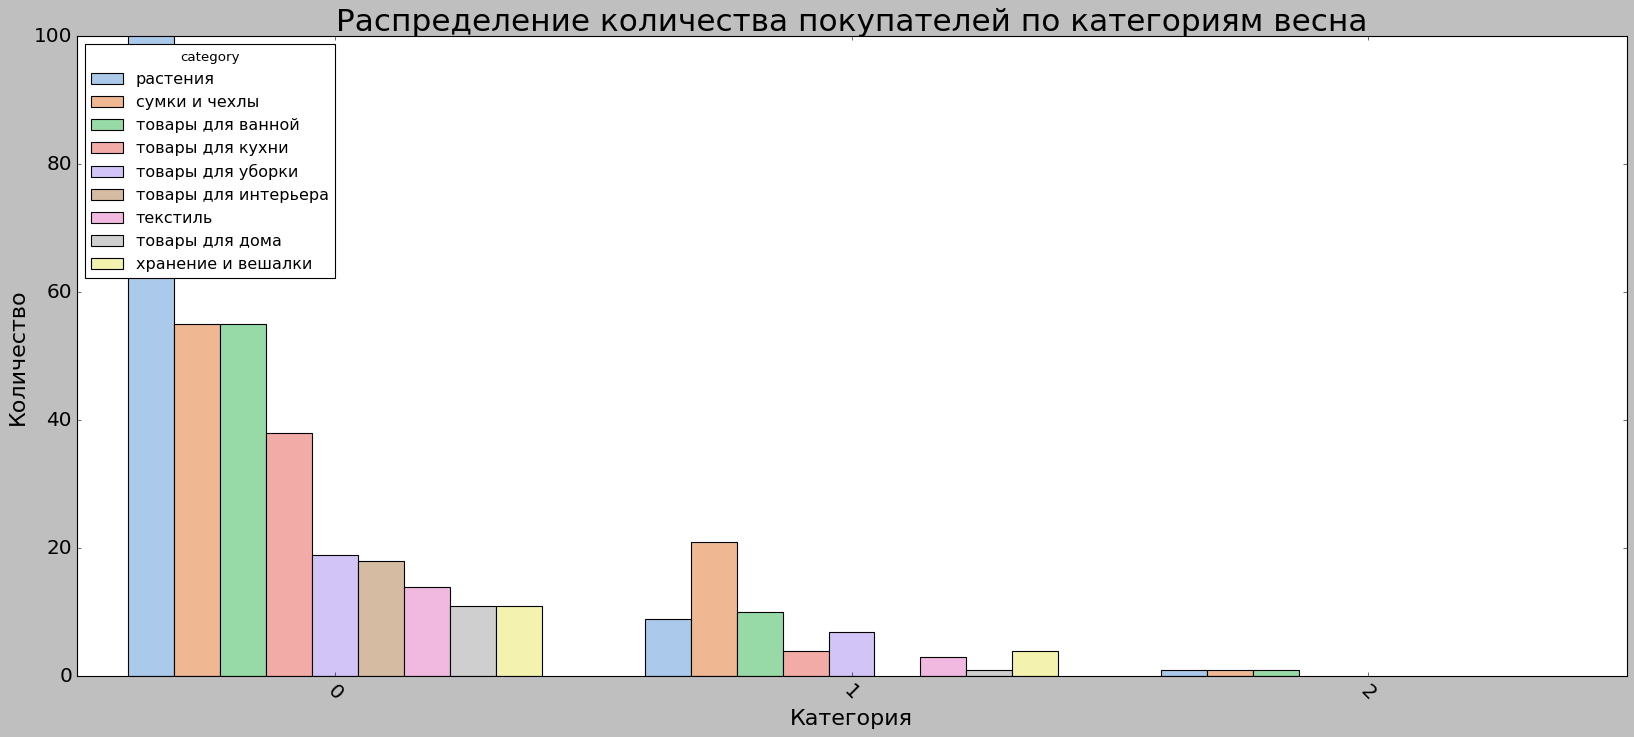

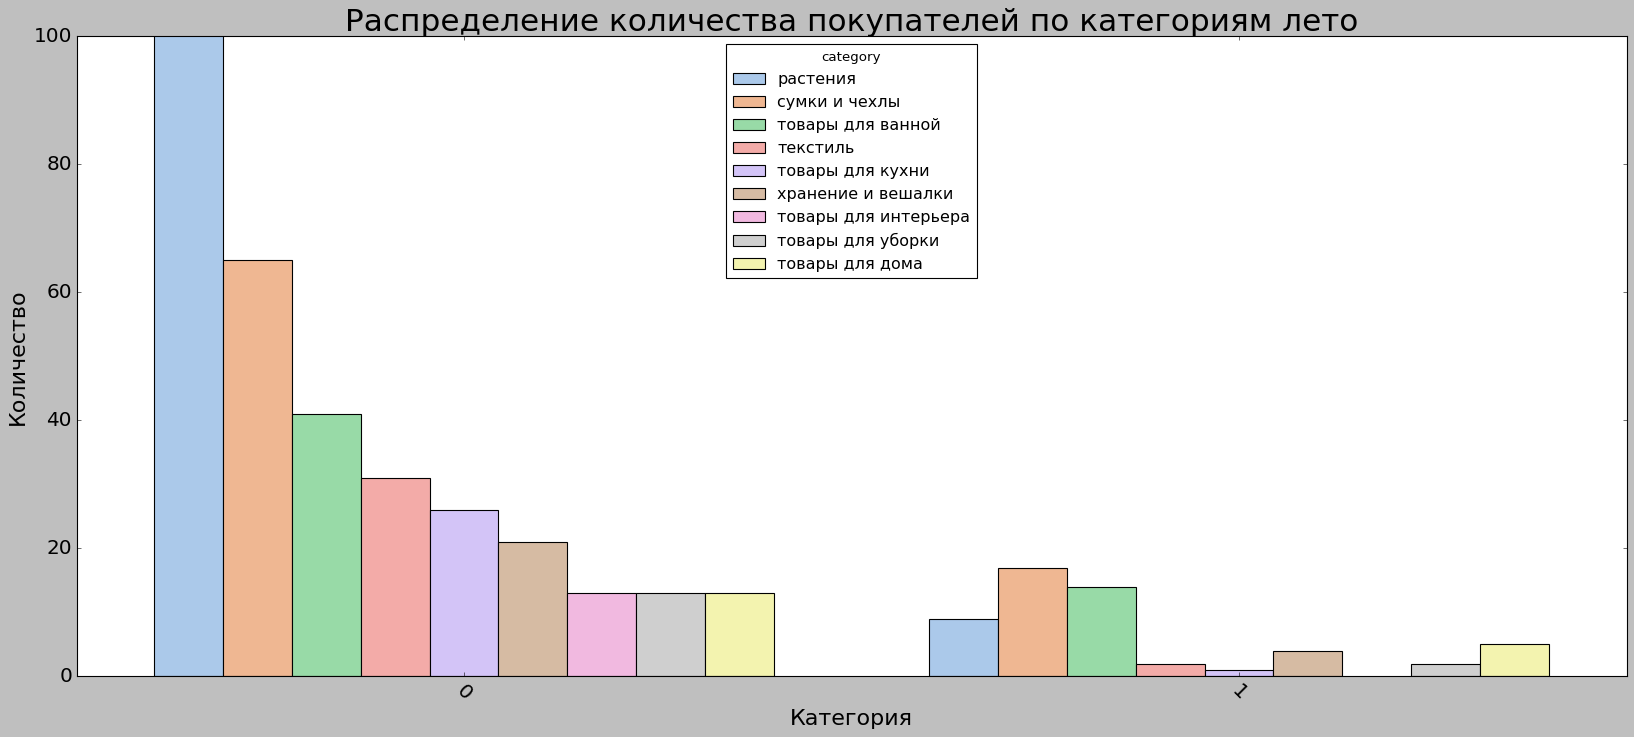

In [80]:
seasons = data['season'].unique().tolist()
for season in seasons:
    data_with_cluster_autumn = data_group(data_with_cluster.query('season == @season'), 
                                          ['cluster_km', 'category'], 
                                          {'customer_id': ['nunique', 'count']},
                                          ['cnt_customer', 'cnt'])
    plotting_bar('cluster_km', 'cnt_customer', 
                 data_with_cluster_autumn, 
                 f'Распределение количества покупателей по категориям {season}', 
                 'Категория', 'Количество', 'category', (25,10), 28, 20, 18, (0, 100))

В нулевом кластере почти во все времена года распределение категорий похожее, только весной у категории сумки и чехлы и категории товары для ванной одинаковое кол-во покупателей, а в остальное время года категория сумки и чехлы преобладает.

В первом кластере категория сумки и чехлы преобладает летом и весной, зимой эту категорию товаров в этом кластере почти не покупают, а осенью она на втором месте. Осенью, весной и зимой отсутсвует категория товары для интерьера.

Во втором кластере 
 - зимой нет товаров категории хранение и вешалки, 
 - весной есть всего три категории: растения, сумки и чехлы и товары для ванной,
 - летом вообще нет клиентов
 - осенью есть все категории без лидеров.

In [81]:
data_group(data_with_cluster, ['cluster_km'],
                             {'season': 'nunique', 'category': 'nunique'},
                             ['cnt_season', 'cnt_category'])

,cluster_km,cnt_season,cnt_category
0,0,4,9
1,1,4,9
2,2,3,9


#### Выводы
<a id="conclusion_clustering_of_users"></a>

Для кластеризации клиентов сначала сгруппировали данные по id клиентов, затем использовали метод К средних. У нас получилось три кластеров с 2092, 251 и 2 покупателями.

Во всех кластерах есть все категории товаров, но не все времена года. Во втором кластере нет одного времени года.

Во всех кластерах больше всего покупателей осенью, меньше всего летом. Во втором кластере нет клиентов летом. В нулевом кластере зимой и весной примерно одинаковое. В первом кластере весной, зимой и летом примерно одинаковое кол-во клиентов. Во втором кластере весной и зисой кол-во клиентов одинаковое.

В нулевом кластере самая популярная категория - растения, ее больше почти в четыре раза выбирают, затем идут сумки и чехлы, товары для ванной, самые непопулярные категории - товары для интерьера, уборки и дома.

В первом кластере самая популярная категория - сумки и чехлы, потом товары для ванной, растения, самые непопулярные категории - товары для кухни, уборки, интерьера.

Во втором кластере все категории равнозначные с 2 клиентами.

В нулевом кластере почти во все времена года распределение категорий похожее, только весной у категории сумки и чехлы и категории товары для ванной одинаковое кол-во покупателей, а в остальное время года категория сумки и чехлы преобладает.

В первом кластере категория сумки и чехлы преобладает летом и весной, зимой эту категорию товаров в этом кластере почти не покупают, а осенью она на втором месте. Осенью, весной и зимой отсутсвует категория товары для интерьера.

Во втором кластере 
 - зимой нет товаров категории хранение и вешалки, 
 - весной есть всего три категории: растения, сумки и чехлы и товары для ванной,
 - летом вообще нет клиентов
 - осенью есть все категории без лидеров.

### Проверка гипотез
<a id="hypothesis_testing"></a> 

In [82]:
def whitneyu(cl, cl1, alpha):
    '''
    Функция для проверки двусторонней гипотезы
    Параметры:
    cl -- первая группа
    cl1 -- вторая группа
    Возвращаемое значение:
    pr - None
    '''
    results = st.mannwhitneyu(cl, cl1, alternative='two-sided')
    print('p-значение: ', results.pvalue)

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средний чек у сегментов пользователей одинаковый}\\
   H_1 :\text{Средний чек у сегментов пользователей отличается}
 \end{cases}
\end{equation*}$



/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

(0.0, 10000.0)

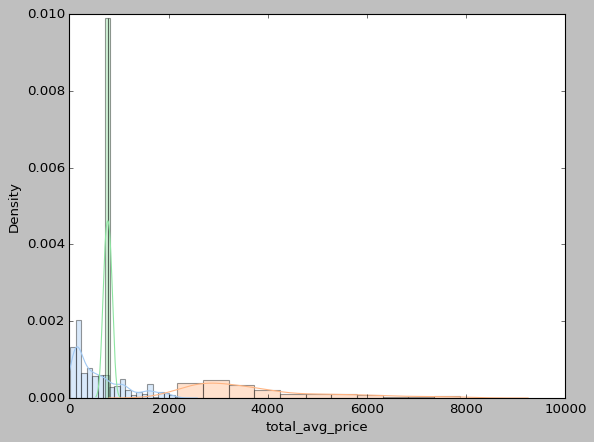

In [83]:
cl_1 = data_clustering.query('cluster_km == 0')['total_avg_price']
cl_2 = data_clustering.query('cluster_km == 1')['total_avg_price']
cl_3 = data_clustering.query('cluster_km == 2')['total_avg_price']

# print(list(combinations(['cl_1', 'cl_2', 'cl_3', 'cl_4', 'cl_5'], 2)))
clasters = [(cl_1, cl_2, 'cl_1, cl_2'), (cl_1, cl_3, 'cl_1, cl_3'), (cl_2, cl_3, 'cl_2, cl_3')]

sns.distplot(cl_1);
sns.distplot(cl_2);
sns.distplot(cl_3);
plt.xlim(0, 10000)

Определим уровень значимости с учетом множественности тестов. Вероятность ошибиться хотя бы раз за k сравнений: 
\begin{equation*}
1-(1-\alpha)^k
\end{equation*}

Посмотрим какая вероятность ошибиться будет для разных уровнях значимости для наших трех сравнений. 

In [84]:
k = 3
alphas = [.05, .01]
for alpha in alphas:
    print((1-(1-alpha)**k)*100)

14.262500000000012
2.9700999999999977


Для уровня значимости 0.05 вероятность хотя бы одного ложнопозитивного результата 14%, для 0.05 примерно 3%.
Уровень значимости: $\alpha = 0.01$

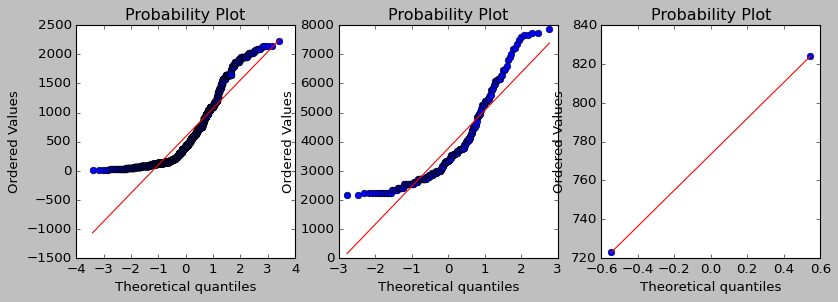

In [85]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
st.probplot(cl_1, dist="norm", plot=plt)
plt.subplot(2,3,2)
st.probplot(cl_2, dist="norm", plot=plt)
plt.subplot(2,3,3)
st.probplot(cl_3, dist="norm", plot=plt)
plt.show()

У кластеров не нормальное распределение, поэтому для проверки гопотез используем тест Манна-Уитни.

In [86]:
alpha = .01
for pair_of_clusters in clasters:
    print('Сравниваем кластеры: ', pair_of_clusters[2])
    whitneyu(pair_of_clusters[0], pair_of_clusters[1], alpha)
    print()

Сравниваем кластеры:  cl_1, cl_2
p-значение:  3.519767301639906e-148
Отвергаем нулевую гипотезу

Сравниваем кластеры:  cl_1, cl_3
p-значение:  0.31230227318403614
Не получилось отвергнуть нулевую гипотезу

Сравниваем кластеры:  cl_2, cl_3
p-значение:  0.01506817031707692
Не получилось отвергнуть нулевую гипотезу



У кластеров 1 и 2 отвергли нулевую гипотезу о равенстве среднего чека, а у кластеров 1 и 3, 2 и 3 не удалось отвергнуть гипотезу о равенстве среднего чека.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Среднее кол-во товаров у сегментов одинаковое одинаковы}\\
   H_1 :\text{Среднее кол-во товаров у сегментов одинаковое отличаются}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.01$

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

(0.0, 50.0)

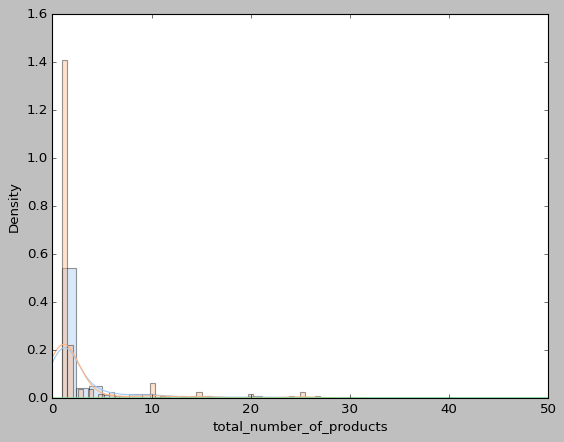

In [87]:
cl_1 = data_clustering.query('cluster_km == 0')['total_number_of_products']
cl_2 = data_clustering.query('cluster_km == 1')['total_number_of_products']
cl_3 = data_clustering.query('cluster_km == 2')['total_number_of_products']

# print(list(combinations(['cl_1', 'cl_2', 'cl_3', 'cl_4', 'cl_5'], 2)))
clasters = [(cl_1, cl_2, 'cl_1, cl_2'), (cl_1, cl_3, 'cl_1, cl_3'), (cl_2, cl_3, 'cl_2, cl_3')]

sns.distplot(cl_1);
sns.distplot(cl_2);
sns.distplot(cl_3);
plt.xlim(0, 50)

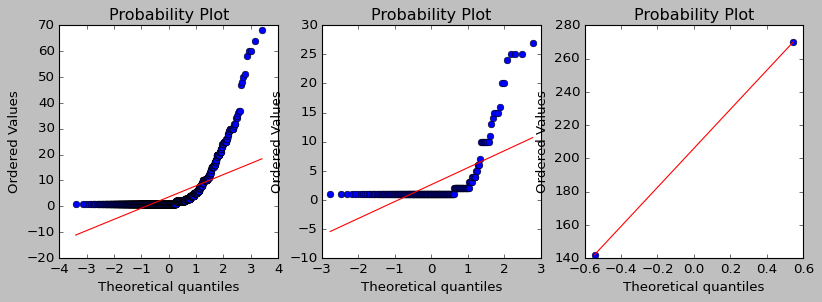

In [88]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
st.probplot(cl_1, dist="norm", plot=plt)
plt.subplot(2,3,2)
st.probplot(cl_2, dist="norm", plot=plt)
plt.subplot(2,3,3)
st.probplot(cl_3, dist="norm", plot=plt)
plt.show()

У кластеров не нормальное распределение, поэтому для проверки гопотез используем тест Манна-Уитни.

In [89]:
for pair_of_clusters in clasters:
    print('Сравниваем кластеры: ', pair_of_clusters[2])
    whitneyu(pair_of_clusters[0], pair_of_clusters[1], alpha)
    print()

Сравниваем кластеры:  cl_1, cl_2
p-значение:  3.770903440253361e-05
Отвергаем нулевую гипотезу

Сравниваем кластеры:  cl_1, cl_3
p-значение:  0.005624284067179861
Отвергаем нулевую гипотезу

Сравниваем кластеры:  cl_2, cl_3
p-значение:  0.0019229860834566162
Отвергаем нулевую гипотезу



У всех кластеров отвергли нулевую гипотезу о равенстве кол-ва товаров в сегменте.

#### Выводы
<a id="conclusion_hypothesis_testing"></a>

Для проверки гипотез мы использовали критерий Манна-Уитни, т.к. распределение не нормальное. Мы попарно сравнили сравнили кластеры и проверили гипотезу
 - первую гипотезу о равенстве среднего чека отвергли только для двух групп, у остальных сегментов не смогли отвергнуть эту гипотезу;
 - вторую гипотезу о равенстве кол-ва товаров отвергли для всех сегментов.


### Выводы
<a id="conclusion"></a> 

Осенью больше всего было покупателей, меньше всего летом, весной и зимой покупателей было примерно одинаково. Возможно это связано с тем, что летом люди уезжают на дачу и в отпуск, а осенью возвращаются в город. Количество заказов максимально также осенью, а минимально летом как и кол-во покупателей. Но зимой кол-во заказов чуть выше, чем весной, хотя кол-во клиентов в эти сезоны одинаковое. Т.е.нельзя сказать о прямой зависимости кол-ва покупателей и кол-ва заказов. Весной больше всего покупают товаров, меньше всего летом. Возможно это связано с началом дачного сезона и закупкой рассады, семян и прочего товара для дачи. Средняя цена за все время - 188, осенью и летом средняя цена чуть выше, весной средняя цена ниже средней цены за год, а зимой почти в два раза выше. Максимальная выручка - осенью, а минимальня летом.

Мы выделили 9 категорий товаров. Больше всего товаров в категории растений, их существенно больше, чем в других категориях. Меньше всего товаров в категории товаров для дома, больше в категории сумки и чехлы. Т.к. в группе растений намного больше товаров, чем в остальных, то не будем учитывать эту категорию. Больше всего покупателей выбирает сумки и чехлы, меньше всего товары для интерьера. Количество заказов распределено также как и количество покупателей по категориям, т.е.между количеством покупателей и количеством заказов по категориям есть прямая связь. Больше всего покупают товары для кухни и для ванной, меньше всего покупают товары для уборки и для дома. Хотя товаров в категории растений больше всего средняя цена в этой категории почти самая маленькая. Самы дорогие товары в категории сумки и чехлы, в категориях товароы для ванной и для дома одинаковая, самые дешевые товары в категории товаров для интерьера. Сумки и чехлы - самая дорогая категория из-за чусок тележек, которые дорогие. Больше всего выручка от товаров категории сумки и чехлы, потом товары для ванны, меньше всего выручка от категории товаров для интерьера.

Весной, летом и зимой самая популярная категория - сумки и чехлы, осенью - товары для ванной. Весной самая непопулярная категория - товары для дома, осенью, летом и зимой - товары для уборки.

Сымый популярный товар - пеларгония, его покупали 269 раз, в топ 10 также входят сушилки, сумки-тележки, гладильная доска, коврик, тележка, рассада, муляж, чехол, штора.

Мы кластеризовали клиентов и получили 3 кластера клиентов с 2092, 251 и 2 покупателями.
Мы проверили две гипотезы:
- нулевая гипотеза: средний чек у всех сегментов одинаковый, альтернативная: средний чек разный;
- нулевая гипотеза: среднее кол-во товаров у всех сегментов одинаковое, альтернативная: среднее кол-во товаров разное.

Для проверки гипотез мы использовали критерий Манна-Уитни, т.к. распределение не нормальное. Мы попарно сравнили сравнили кластеры и проверили гипотезу
 - первую гипотезу о равенстве среднего чека отвергли только для двух групп, у остальных сегментов не смогли отвергнуть эту гипотезу;
 - вторую гипотезу о равенстве кол-ва товаров отвергли для всех сегментов. 

У нас получилось три кластера:
- **0 кластер** с 2092 покупателями с 2275 заказами с 48103 товарами и средней ценой 164 рубля. Общая выручка этого кластера 1664832. Больше всего покупателей осенью, меньше всего летом, весной и зимой примерно одинаковое кол-во. Зимой самая высокая средняя стоимость заказа, потом осенью, летом и весной. Летом и весной примерно одинаковая средняя стоимость заказа. Самая популярная категория - растения, ее больше почти в четыре раза выбирают, затем идут сумки и чехлы, товары для ванной, самые непопулярные категории - товары для интерьера, уборки и дома. Весной у категории сумки и чехлы и категории товары для ванной одинаковое кол-во покупателей. Самая высокая средняя стоимость заказа у категории сумки и чехлы, хранение и вешалки, товары для ванной, самая низкая у категорий растения и товары для интерьера. Рекомендуем рассмотреть для рекламы без привязки к времени года категории: растения, сумки и чехлы и товары для ванной;
- **1 кластер** с 251 покупателем с 262 заказами с 696 товарами и средней ценой 3329 рубля. Общая выручка этого кластера 1000226. Больше всего покупателей осенью, меньше всего летом, весной и зимой примерно одинаковое кол-во. Самая высокая средняя цена летом, осенью, зимой и летом. Зимой и летом примерно одинаковая средняя стоимость заказа. Самая популярная категория - сумки и чехлы, потом товары для ванной, растения, самые непопулярные категории - товары для кухни, уборки, интерьера. Категория сумки и чехлы преобладает летом и весной, зимой эту категорию товаров в этом кластере почти не покупают, а осенью она на втором месте. Осенью, весной и зимой отсутсвует категория товары для интерьера. Самая высокая средняя цена у категории товары для интерьера, текстиль, растения, самая низкая цена у категорий товары для ванной, уборки и кухни. Рекомендуем рассмотреть для рекламы осенью, весной и летом категории: сумки и чехлы, товары для ванной и растения, а зимой: сумки и чехлы, товары для ванной и товары для дома;
- **2 кластер** с 2 покупателями со 157 заказами с 44162 товарами и средней ценой 723 рубля. Общая выручка этого кластера 136450. Больше всего покупателей осенью, летом клиентов этого сегмента нет, весной и зимой одинаковое кол-во. Самая высокая средняя цена зимой, осенью и весной. Все категории равнозначные зимой нет товаров категории хранение и вешалки, весной есть всего три категории: растения, сумки и чехлы и товары для ванной, осенью есть все категории без лидеров. Самая высокая средняя цена у категории хранения и вешалки, сумки и чехлы, товары для ванной и текстиль, самая низкая цена у категорий товары для дома, растения и товары для интерьера. Рекомендуем рассмотреть для рекламы осенью все категории товаров, зимой все категории, кроме хранение и вешалки, весной одну из категорий растения, сумки и чехлы и товары для ванной, летом клиентов этого сегмента нет.